# Predicting Baseball Game Attendance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('poster')
pd.options.display.max_columns = 30

In [2]:
all_teams = pd.read_csv('../data/mlb-game-data-1990-2016.csv')
all_teams.drop_duplicates(inplace=True)

In [3]:
all_teams.head()

date       box team  at opponent w_or_l  runs  runs_allowed  innings  \
0  1997-04-02  boxscore  ANA NaN      BOS      L     5             6      NaN   
1  1997-04-03  boxscore  ANA NaN      BOS      W     2             0      NaN   
2  1997-04-04  boxscore  ANA NaN      CLE   W-wo     8             6     11.0   
3  1997-04-05  boxscore  ANA NaN      CLE      L     5             7      NaN   
4  1997-04-06  boxscore  ANA NaN      CLE      L     8            10      NaN   

  record  div_rank     gb winning_pitcher losing_pitcher     save  time  \
0    0-0         0      0         Mahomes       Percival  Slocumb  3:47   
1    0-1         3    1.0         Dickson      Wakefield      NaN  2:07   
2    1-1         2    0.5           Holtz          Shuey      NaN  4:12   
3    2-1         1   Tied            Ogea       Hasegawa    Shuey  3:09   
4    2-2         1   Tied           Kline       Percival  Jackson  3:24   

  d_or_n attendance streak  double_header  runs_pg  runs_ma  runs_allowed_ma  \
0      N     30,874      0              0      0.0      NaN              5.8   
1      N     17,323      -              0      5.0      NaN              5.8   
2      N     17,758      +              0      3.5      NaN              5.8   
3      N     23,913     ++              0      5.0      NaN              5.8   
4      N     29,363      -              0      5.0      NaN              5.8   

   ten_game  opening_day  
0       NaN            1  
1       NaN            0  
2       NaN            0  
3       NaN            0  
4       NaN            0

In [4]:
print all_teams[(all_teams.attendance.isnull()) & (all_teams.double_header == 1)].shape
print all_teams[(all_teams.attendance.isnull()) & (all_teams.double_header == 0)].shape
# not safe to assume that the attendance numbers were the same for each of the games in the double header
# so we must drop these rows

print
print all_teams[(all_teams.attendance.notnull()) & (all_teams.double_header == 1)].shape
# still have enough records to keep the double header feature

(473, 25)
(4, 25)

(1019, 25)


In [5]:
# drop rows without attendance recorded and drop duplicated rows
all_teams = all_teams[all_teams.attendance.notnull()]

# convert datatypes where needed
all_teams.attendance = all_teams.attendance.str.replace(',', '').astype(int)

for col in ['runs', 'runs_allowed', 'div_rank']:
    all_teams[col] = all_teams[col].astype(int)

# create wins, losses, and win pct column
wins = []
losses = []
for wl in all_teams.record:
    w, l = wl.split('-')
    wins.append(int(w))
    losses.append(int(l))

all_teams['wins'] = wins
all_teams['losses'] = losses
all_teams['total_games'] = all_teams.wins + all_teams.losses
all_teams['win_pct'] = all_teams.wins / all_teams.total_games

# convert gb column to floats
all_teams.gb = [0. if x == ' Tied' or x == '0'
         else float(x.replace('up', '')) if 'up' in x
         else -float(x)
         for x in all_teams.gb]

# convert streak column to int
all_teams.streak.fillna('0', inplace=True)
all_teams.streak = [len(x) if '+' in x else -len(x) if '-' in x else 0 for x in all_teams.streak]

# convert d_or_n to dummy variable
all_teams['night_game'] = [1 if x == 'N' else 0 for x in all_teams.d_or_n]

# convert date to datetime
all_teams.date = pd.to_datetime(all_teams.date)
all_teams['year'] = all_teams.date.dt.year
all_teams['month'] = all_teams.date.dt.month
all_teams['day'] = all_teams.date.dt.day
all_teams['weekday'] = all_teams.date.dt.weekday
all_teams['weekday_name'] = all_teams.date.dt.weekday_name

# convert time to timedelta
all_teams.time = pd.to_timedelta([x + ':00' for x in all_teams.time])

# replace null values for win_pct, replacing with zero since first game of season
all_teams.win_pct.fillna(0, inplace=True)

# fill null values for runs_ma and ten_game
all_teams.runs_ma = [all_teams.iloc[i].runs_pg if np.isnan(j) else j for i, j in enumerate(all_teams.runs_ma)]
all_teams.ten_game = [all_teams.iloc[i].win_pct if np.isnan(j) else j for i, j in enumerate(all_teams.ten_game)]

# drop useless columns
all_teams.drop(['box', 'at', 'w_or_l', 'runs', 'runs_allowed', 'innings', 'record', 'winning_pitcher',
                'losing_pitcher', 'save', 'd_or_n', 'wins', 'losses'], axis=1, inplace=True)

In [6]:
print all_teams.shape
print 
print all_teams.dtypes
print
print all_teams.isnull().sum()
print
all_teams.head(15)

(62415, 22)

date                datetime64[ns]
team                        object
opponent                    object
div_rank                     int64
gb                         float64
time               timedelta64[ns]
attendance                   int64
streak                       int64
double_header                int64
runs_pg                    float64
runs_ma                    float64
runs_allowed_ma            float64
ten_game                   float64
opening_day                  int64
total_games                  int64
win_pct                    float64
night_game                   int64
year                         int64
month                        int64
day                          int64
weekday                      int64
weekday_name                object
dtype: object

date               0
team               0
opponent           0
div_rank           0
gb                 0
time               0
attendance         0
streak             0
double_header      0
runs_pg      

date team opponent  div_rank   gb     time  attendance  streak  \
0  1997-04-02  ANA      BOS         0  0.0 03:47:00       30874       0   
1  1997-04-03  ANA      BOS         3 -1.0 02:07:00       17323      -1   
2  1997-04-04  ANA      CLE         2 -0.5 04:12:00       17758       1   
3  1997-04-05  ANA      CLE         1  0.0 03:09:00       23913       2   
4  1997-04-06  ANA      CLE         1  0.0 03:24:00       29363      -1   
5  1997-04-07  ANA      NYY         3 -1.0 03:24:00       16514      -2   
6  1997-04-08  ANA      NYY         3 -2.0 04:18:00       17202      -3   
7  1997-04-09  ANA      NYY         2 -1.0 02:52:00       19242       1   
8  1997-04-21  ANA      TOR         4 -3.0 04:04:00       13413       1   
9  1997-04-22  ANA      TOR         4 -3.0 02:44:00       13353       2   
10 1997-04-23  ANA      TOR         4 -4.0 03:13:00       13117      -1   
11 1997-04-25  ANA      DET         4 -3.0 02:49:00       30464       1   
12 1997-04-26  ANA      DET         3 -3.0 02:18:00       30872       2   
13 1997-04-27  ANA      DET         4 -3.0 03:06:00       16409      -1   
14 1997-05-12  ANA      CHW         3 -6.0 03:44:00       14540      -5   

    double_header   runs_pg  runs_ma  runs_allowed_ma  ten_game  opening_day  \
0               0  0.000000      0.0              5.8  0.000000            1   
1               0  5.000000      5.0              5.8  0.000000            0   
2               0  3.500000      3.5              5.8  0.500000            0   
3               0  5.000000      5.0              5.8  0.666667            0   
4               0  5.000000      5.0              5.8  0.500000            0   
5               0  5.600000      5.6              5.8  0.400000            0   
6               0  5.166667      5.2              5.6  0.333333            0   
7               0  5.857143      6.8              7.4  0.428571            0   
8               0  5.437500      5.0              4.2  0.400000            0   
9               0  5.411765      4.8              4.0  0.400000            0   
10              0  5.444444      5.6              4.6  0.400000            0   
11              0  5.421053      6.0              4.6  0.400000            0   
12              0  5.550000      7.0              3.8  0.400000            0   
13              0  5.285714      4.8              4.0  0.300000            0   
14              0  4.575758      2.6              5.0  0.200000            0   

    total_games   win_pct  night_game  year  month  day  weekday weekday_name  
0             0  0.000000           1  1997      4    2        2    Wednesday  
1             1  0.000000           1  1997      4    3        3     Thursday  
2             2  0.500000           1  1997      4    4        4       Friday  
3             3  0.666667           1  1997      4    5        5     Saturday  
4             4  0.500000           1  1997      4    6        6       Sunday  
5             5  0.400000           1  1997      4    7        0       Monday  
6             6  0.333333           1  1997      4    8        1      Tuesday  
7             7  0.428571           1  1997      4    9        2    Wednesday  
8            16  0.437500           1  1997      4   21        0       Monday  
9            17  0.470588           1  1997      4   22        1      Tuesday  
10           18  0.444444           1  1997      4   23        2    Wednesday  
11           19  0.473684           1  1997      4   25        4       Friday  
12           20  0.500000           1  1997      4   26        5     Saturday  
13           21  0.476190           0  1997      4   27        6       Sunday  
14           33  0.424242           1  1997      5   12        0       Monday

In [7]:
sc = pd.read_csv('../data/MLB-stadium-capacity.csv')

In [8]:
sc.columns = [x.lower() for x in sc.columns]
sc.tail()

team  year          state         stadium  capacity
783  WSN  2012  Washington DC  Nationals Park     41487
784  WSN  2013  Washington DC  Nationals Park     41418
785  WSN  2014  Washington DC  Nationals Park     41418
786  WSN  2015  Washington DC  Nationals Park     41418
787  WSN  2016  Washington DC  Nationals Park     41313

In [9]:
all_teams = all_teams.merge(sc.drop('state', axis=1), on=['team', 'year'])
print all_teams.isnull().sum()
all_teams.tail()

date               0
team               0
opponent           0
div_rank           0
gb                 0
time               0
attendance         0
streak             0
double_header      0
runs_pg            0
runs_ma            0
runs_allowed_ma    0
ten_game           0
opening_day        0
total_games        0
win_pct            0
night_game         0
year               0
month              0
day                0
weekday            0
weekday_name       0
stadium            0
capacity           0
dtype: int64


date team opponent  div_rank   gb     time  attendance  streak  \
62410 2016-09-25  TOR      NYY         2 -5.5 03:19:00       47896       2   
62411 2016-09-26  TOR      NYY         2 -5.5 03:22:00       44532       3   
62412 2016-09-27  TOR      BAL         2 -6.0 02:39:00       44762      -1   
62413 2016-09-28  TOR      BAL         2 -5.0 03:04:00       44668       1   
62414 2016-09-29  TOR      BAL         2 -5.0 02:35:00       47791      -1   

       double_header   runs_pg  runs_ma  runs_allowed_ma  ten_game  \
62410              0  4.766234      5.2              1.2       0.6   
62411              0  4.761290      5.4              1.4       0.6   
62412              0  4.762821      4.4              2.4       0.5   
62413              0  4.764331      5.2              2.2       0.5   
62414              0  4.746835      3.8              2.8       0.5   

       opening_day  total_games   win_pct  night_game  year  month  day  \
62410            0          154  0.551948           0  2016      9   25   
62411            0          155  0.554839           1  2016      9   26   
62412            0          156  0.551282           1  2016      9   27   
62413            0          157  0.554140           1  2016      9   28   
62414            0          158  0.550633           1  2016      9   29   

       weekday weekday_name        stadium  capacity  
62410        6       Sunday  Rogers Centre     49282  
62411        0       Monday  Rogers Centre     49282  
62412        1      Tuesday  Rogers Centre     49282  
62413        2    Wednesday  Rogers Centre     49282  
62414        3     Thursday  Rogers Centre     49282

## Year-by-Year Stats

In [10]:
yearly = pd.read_csv('../data/franchise-yearly-data.csv')

In [11]:
print yearly.isnull().sum()
print
print yearly.dtypes
yearly.tail()

year            0
team            0
team_name       0
division        0
G               0
W               0
L               0
ties            0
win_pct         0
p_win_pct       0
finish          0
gb              0
playoffs      663
R               0
RA              0
attendance      0
bat_age         0
pitch_age       0
num_bat         0
num_pitch       0
top_player      0
managers        0
dtype: int64

year            int64
team           object
team_name      object
division       object
G               int64
W               int64
L               int64
ties            int64
win_pct       float64
p_win_pct     float64
finish         object
gb             object
playoffs       object
R               int64
RA              int64
attendance     object
bat_age       float64
pitch_age     float64
num_bat         int64
num_pitch       int64
top_player     object
managers       object
dtype: object


year team       team_name division    G   W   L  ties  win_pct  \
880  1994  WSN  Montreal Expos  NL East  114  74  40     0    0.649   
881  1993  WSN  Montreal Expos  NL East  163  94  68     1    0.580   
882  1992  WSN  Montreal Expos  NL East  162  87  75     0    0.537   
883  1991  WSN  Montreal Expos  NL East  161  71  90     0    0.441   
884  1990  WSN  Montreal Expos  NL East  162  85  77     0    0.525   

     p_win_pct    finish    gb playoffs    R   RA attendance  bat_age  \
880      0.614  1st of 5    --      NaN  585  454  1,276,250     26.2   
881      0.532  2nd of 7   3.0      NaN  732  682  1,641,437     25.7   
882      0.550  2nd of 6   9.0      NaN  648  581  1,669,127     27.4   
883      0.444  6th of 6  26.5      NaN  579  655    934,742     27.7   
884      0.546  3rd of 6  10.0      NaN  662  598  1,373,087     27.7   

     pitch_age  num_bat  num_pitch        top_player  \
880       26.2       32         16      M.Alou (5.1)   
881       27.9       48         22   M.Grissom (5.2)   
882       28.0       47         21   M.Grissom (5.4)   
883       28.4       38         19  D.Martinez (5.8)   
884       29.3       44         24  D.Martinez (4.3)   

                                     managers  
880                            F.Alou (74-40)  
881                            F.Alou (94-68)  
882     T.Runnells (17-20) and F.Alou (70-55)  
883  B.Rodgers (20-29) and T.Runnells (51-61)  
884                         B.Rodgers (85-77)

In [12]:
# fix gb columns and convert to float
yearly.gb = [0. if i =='--' else float(i) for i in yearly.gb]

# playoffs dummy
yearly.playoffs = [0 if str(i) == 'nan' else 2 if 'Won' in str(i) else 1 for i in yearly.playoffs]

# split top_player columns into player and WAR columns
top_player = []
WAR = []
for player in yearly.top_player:
    p, w = player.split()
    top_player.append(p)
    WAR.append(float(w.replace('(', '').replace(')', '')))
    
yearly.top_player = top_player
yearly['WAR'] = WAR

# attendance to int
yearly.attendance = yearly.attendance.str.replace(',', '').astype(int)

# drop unnecessary rows
yearly.drop(['W', 'L', 'ties', 'p_win_pct', 'finish', 'R', 'RA', 'num_bat', 'num_pitch', 'managers'],
            axis=1, inplace=True)

In [13]:
yearly.head()

year team                      team_name division    G  win_pct    gb  \
0  2016  ANA  Los Angeles Angels of Anaheim  AL West  162    0.457  21.0   
1  2015  ANA  Los Angeles Angels of Anaheim  AL West  162    0.525   3.0   
2  2014  ANA  Los Angeles Angels of Anaheim  AL West  162    0.605   0.0   
3  2013  ANA  Los Angeles Angels of Anaheim  AL West  162    0.481  18.0   
4  2012  ANA  Los Angeles Angels of Anaheim  AL West  162    0.549   5.0   

   playoffs  attendance  bat_age  pitch_age top_player   WAR  
0         0     3016142     28.5       28.4    M.Trout  10.4  
1         0     3012765     28.6       28.3    M.Trout   9.3  
2         1     3095935     29.3       28.4    M.Trout   8.0  
3         0     3019505     27.8       29.1    M.Trout   9.3  
4         0     3061770     28.8       30.1    M.Trout  10.8

In [14]:
all_teams[(all_teams.year == 2016) & (all_teams.team == 'LAA')].attendance.sum()

3016142

In [15]:
yearly[yearly.team_name == 'Montreal Expos']

year team       team_name division    G  win_pct    gb  playoffs  \
870  2004  WSN  Montreal Expos  NL East  162    0.414  29.0         0   
871  2003  WSN  Montreal Expos  NL East  162    0.512  18.0         0   
872  2002  WSN  Montreal Expos  NL East  162    0.512  19.0         0   
873  2001  WSN  Montreal Expos  NL East  162    0.420  20.0         0   
874  2000  WSN  Montreal Expos  NL East  162    0.414  28.0         0   
875  1999  WSN  Montreal Expos  NL East  162    0.420  35.0         0   
876  1998  WSN  Montreal Expos  NL East  162    0.401  41.0         0   
877  1997  WSN  Montreal Expos  NL East  162    0.481  23.0         0   
878  1996  WSN  Montreal Expos  NL East  162    0.543   8.0         0   
879  1995  WSN  Montreal Expos  NL East  144    0.458  24.0         0   
880  1994  WSN  Montreal Expos  NL East  114    0.649   0.0         0   
881  1993  WSN  Montreal Expos  NL East  163    0.580   3.0         0   
882  1992  WSN  Montreal Expos  NL East  162    0.537   9.0         0   
883  1991  WSN  Montreal Expos  NL East  161    0.441  26.5         0   
884  1990  WSN  Montreal Expos  NL East  162    0.525  10.0         0   

     attendance  bat_age  pitch_age   top_player  WAR  
870      749550     27.5       26.5  L.Hernandez  5.8  
871     1025639     27.7       26.7  L.Hernandez  6.4  
872      812045     28.2       27.7   V.Guerrero  7.0  
873      642745     27.6       27.4    J.Vazquez  6.3  
874      926272     26.2       26.1   V.Guerrero  5.9  
875      773277     25.9       25.5   V.Guerrero  4.4  
876      914909     25.9       25.7   V.Guerrero  7.4  
877     1497609     27.7       26.4   P.Martinez  8.8  
878     1616709     27.4       27.5    J.Fassero  5.3  
879     1309618     26.2       27.6   P.Martinez  4.2  
880     1276250     26.2       26.2       M.Alou  5.1  
881     1641437     25.7       27.9    M.Grissom  5.2  
882     1669127     27.4       28.0    M.Grissom  5.4  
883      934742     27.7       28.4   D.Martinez  5.8  
884     1373087     27.7       29.3   D.Martinez  4.3

In [16]:
yearly.loc[870:884, 'team']  = 'MON'

In [17]:
num_games = pd.DataFrame(columns=['team', 'year', 'num_home_games'])
for i in all_teams.team.unique():
    for j in all_teams[all_teams.team == i].year.unique():
        num_games.loc[len(num_games)] = [i, j, float(len(all_teams[(all_teams.year == j) & (all_teams.team == i)]))]
        
yearly = yearly.merge(num_games, on=['team', 'year'])
yearly['avg_att_pg'] = yearly.attendance / yearly.num_home_games

In [18]:
yearly = sc.drop('state', axis=1).merge(yearly, on=['team', 'year'])

In [19]:
print yearly.dtypes
yearly.tail()

team               object
year               object
stadium            object
capacity            int64
team_name          object
division           object
G                   int64
win_pct           float64
gb                float64
playoffs            int64
attendance          int64
bat_age           float64
pitch_age         float64
top_player         object
WAR               float64
num_home_games    float64
avg_att_pg        float64
dtype: object


team  year         stadium  capacity             team_name division    G  \
783  WSN  2012  Nationals Park     41487  Washington Nationals  NL East  162   
784  WSN  2013  Nationals Park     41418  Washington Nationals  NL East  162   
785  WSN  2014  Nationals Park     41418  Washington Nationals  NL East  162   
786  WSN  2015  Nationals Park     41418  Washington Nationals  NL East  162   
787  WSN  2016  Nationals Park     41313  Washington Nationals  NL East  162   

     win_pct    gb  playoffs  attendance  bat_age  pitch_age    top_player  \
783    0.605   0.0         1     2370794     27.2       27.0  J.Zimmermann   
784    0.531  10.0         0     2652422     27.7       27.7       J.Werth   
785    0.593   0.0         1     2579389     28.8       28.3      A.Rendon   
786    0.512   7.0         0     2619843     28.4       28.6      B.Harper   
787    0.586   0.0         1     2481938     28.8       29.1    M.Scherzer   

      WAR  num_home_games    avg_att_pg  
783   5.4            79.0  30010.050633  
784   4.7            81.0  32745.950617  
785   6.5            81.0  31844.308642  
786  10.1            81.0  32343.740741  
787   6.1            81.0  30641.209877

## Plotting

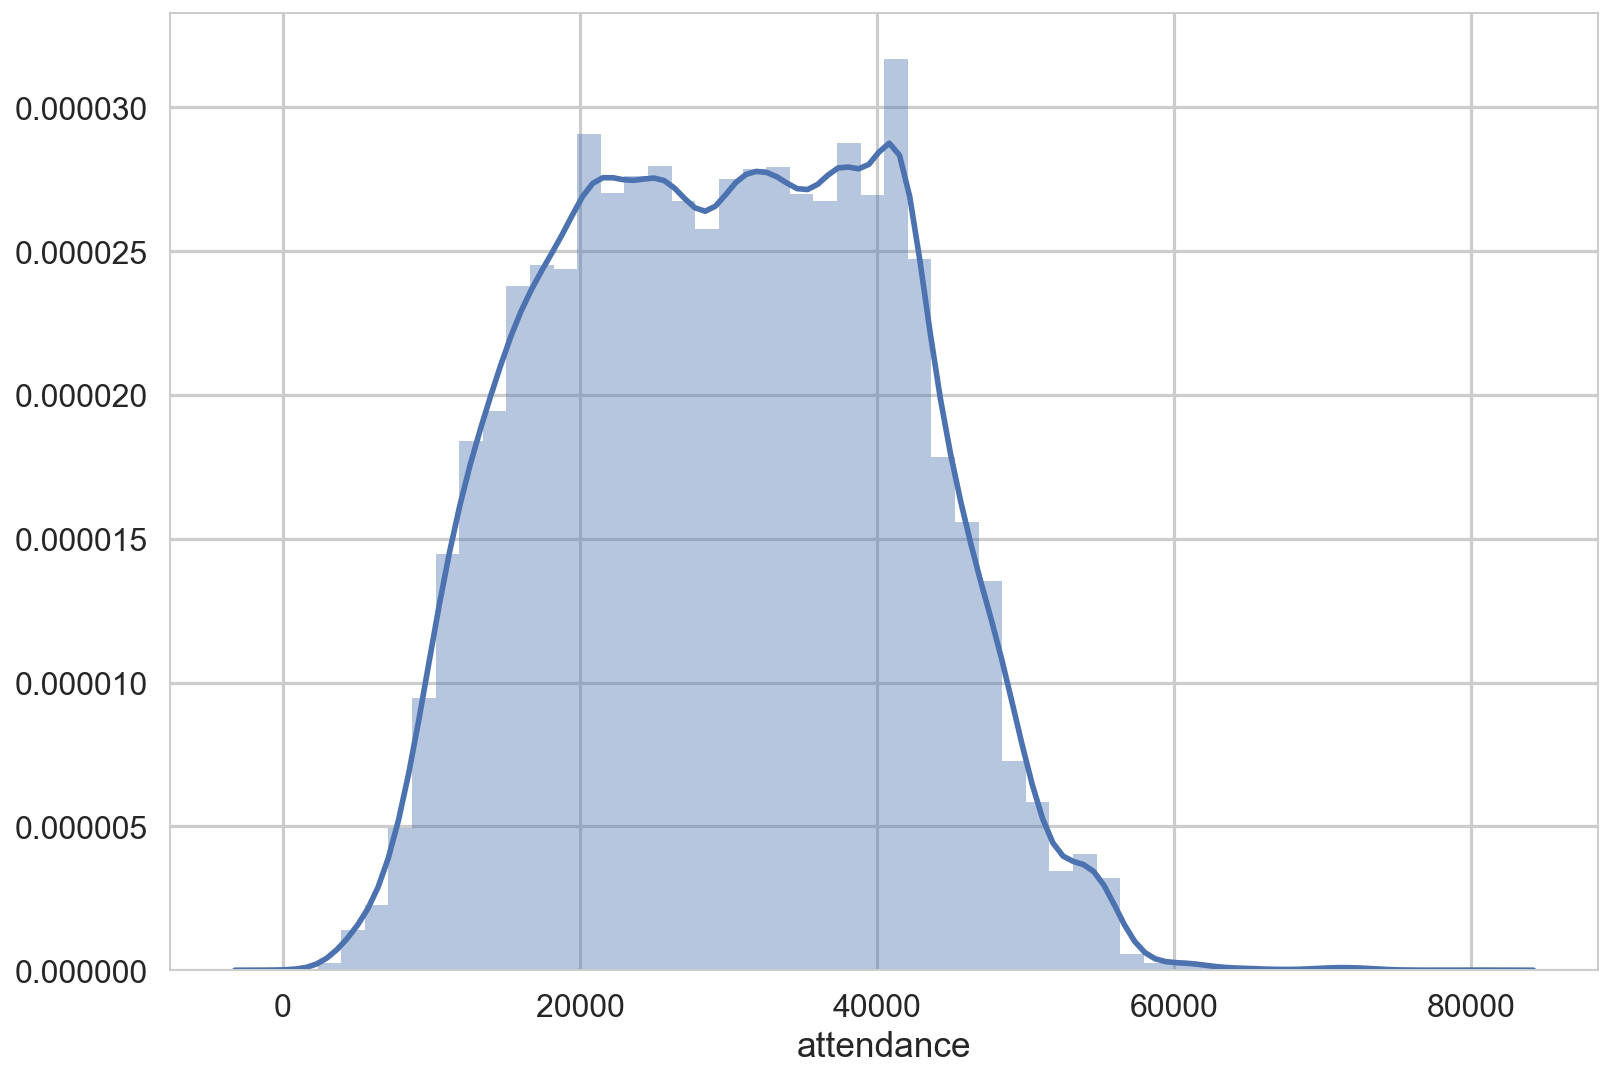

In [20]:
sns.distplot(all_teams.attendance)

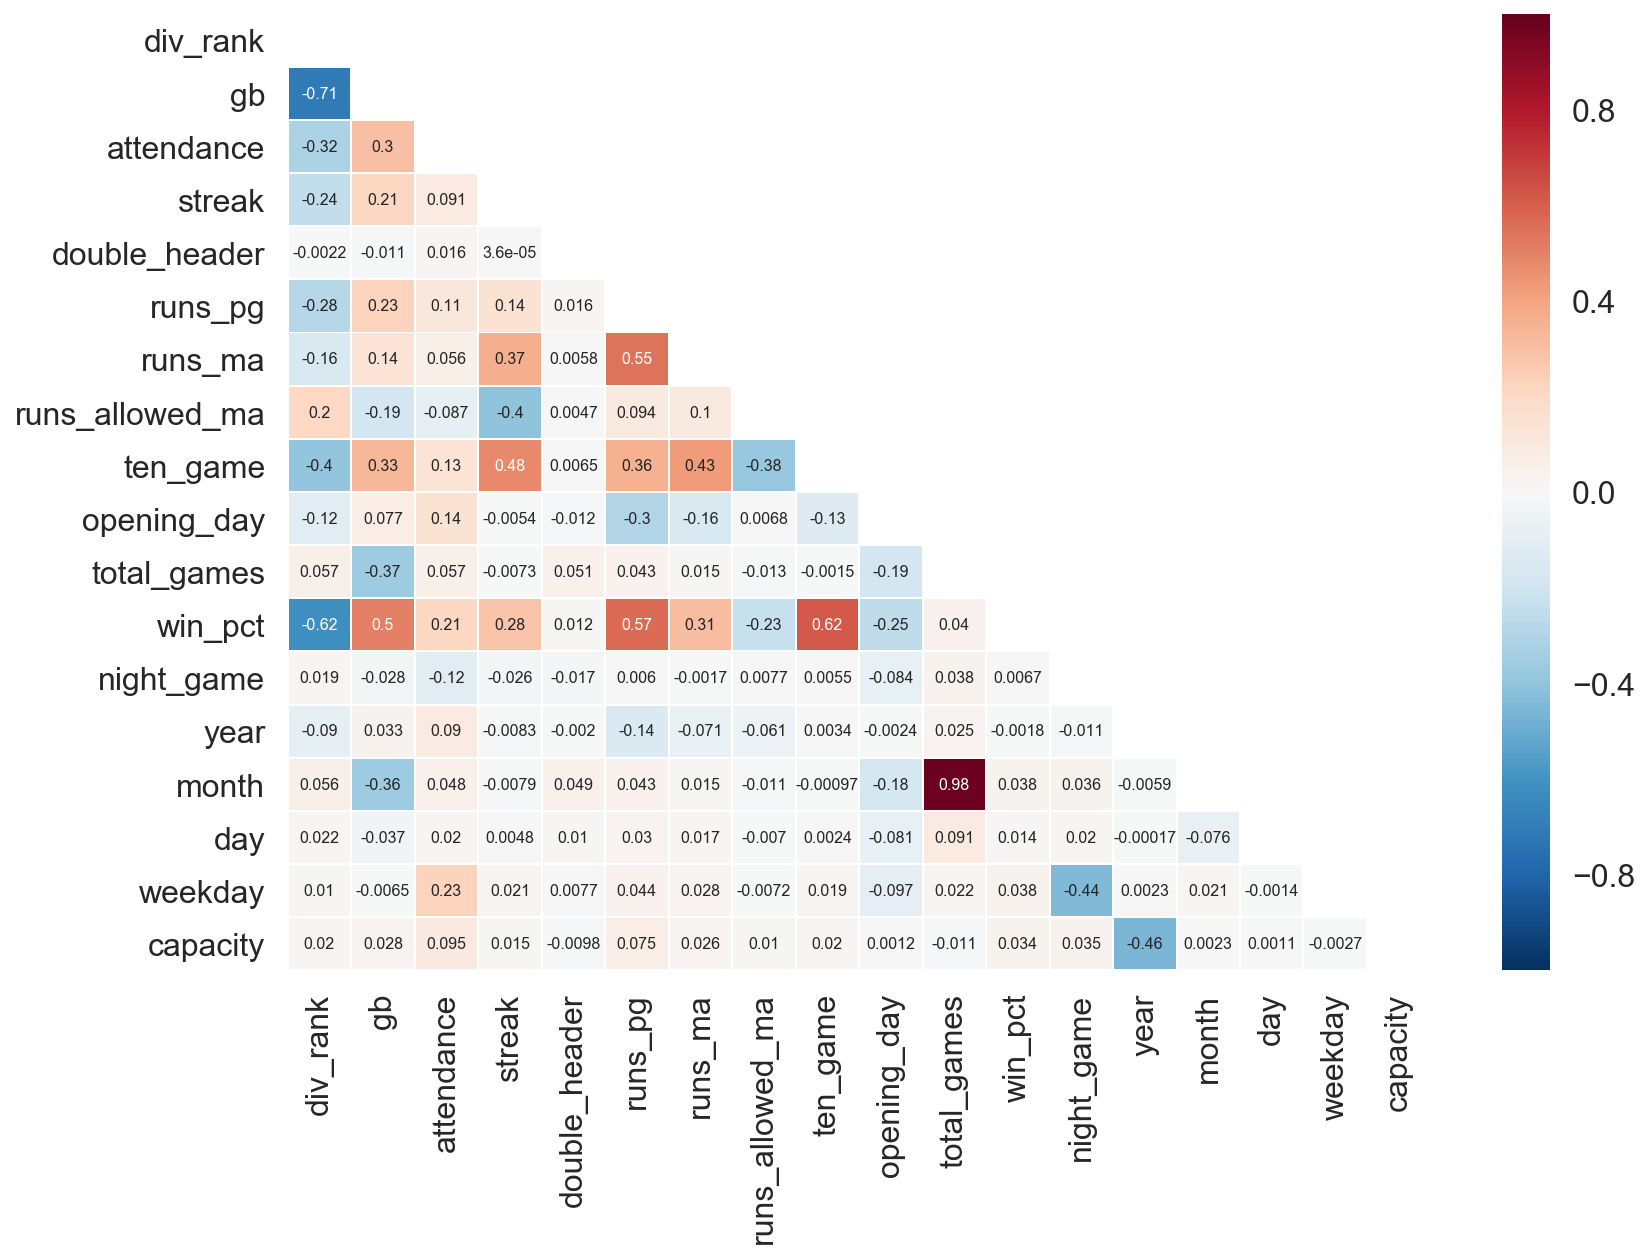

In [21]:
corr = all_teams.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 8})

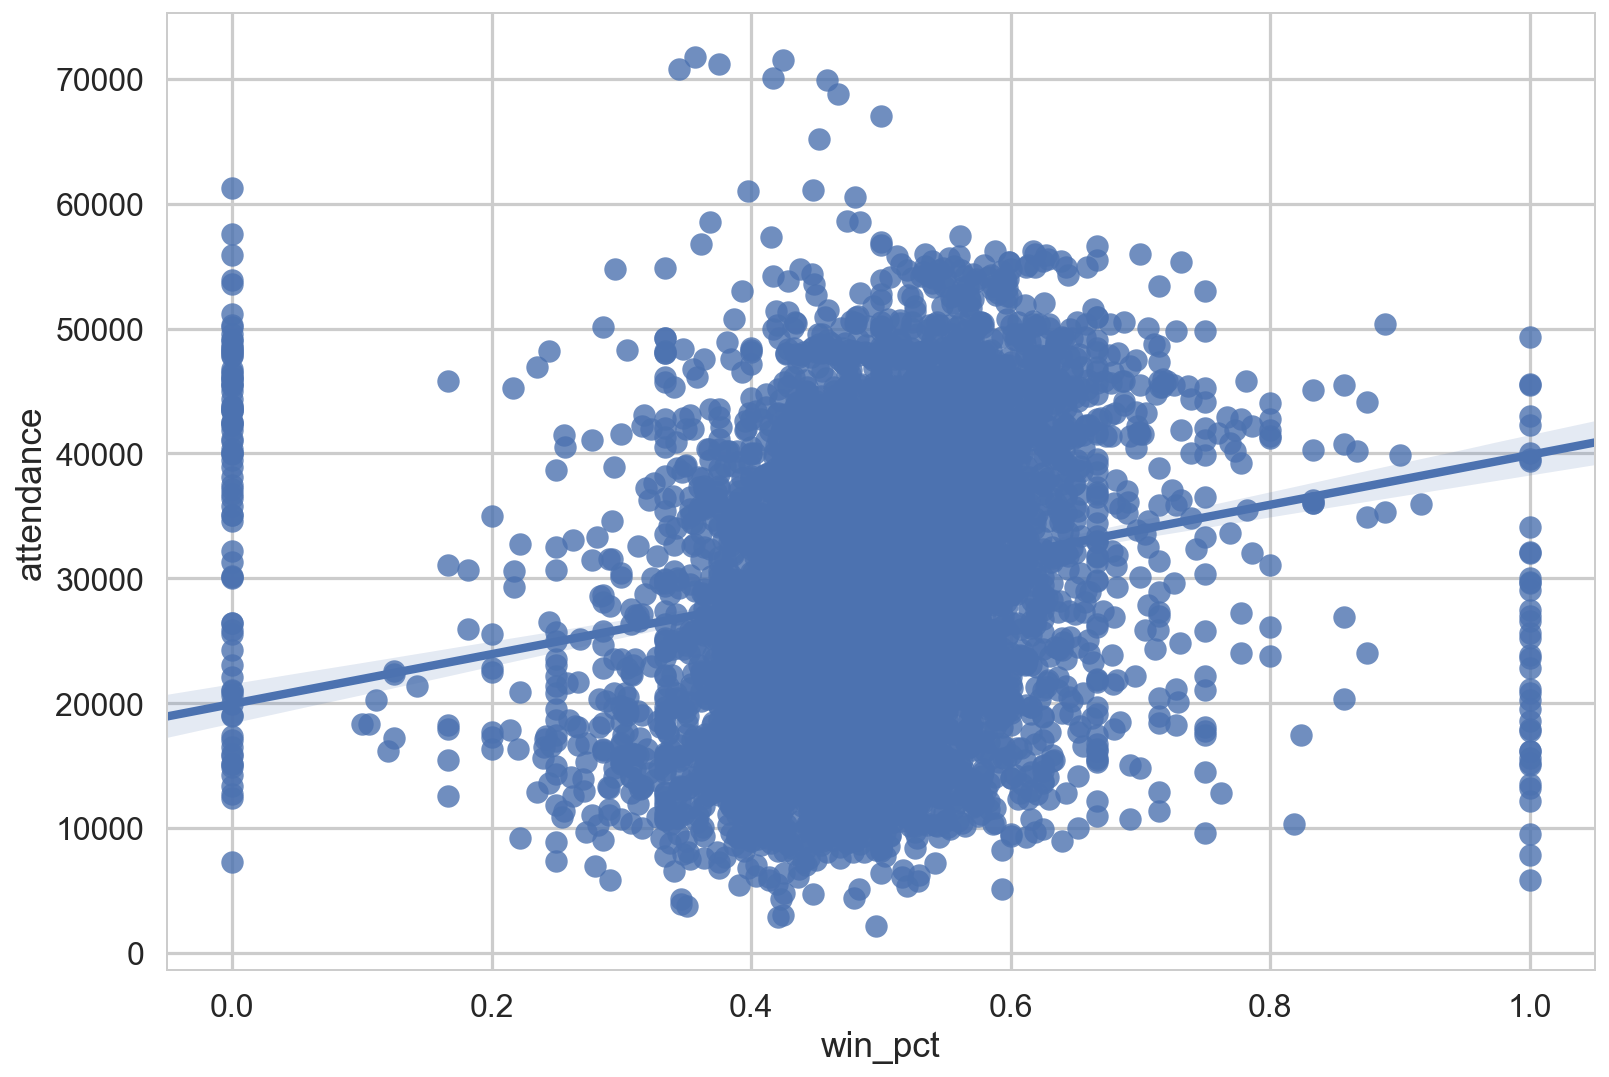

In [22]:
sns.regplot(x='win_pct', y='attendance', data=all_teams.sample(frac=.1))

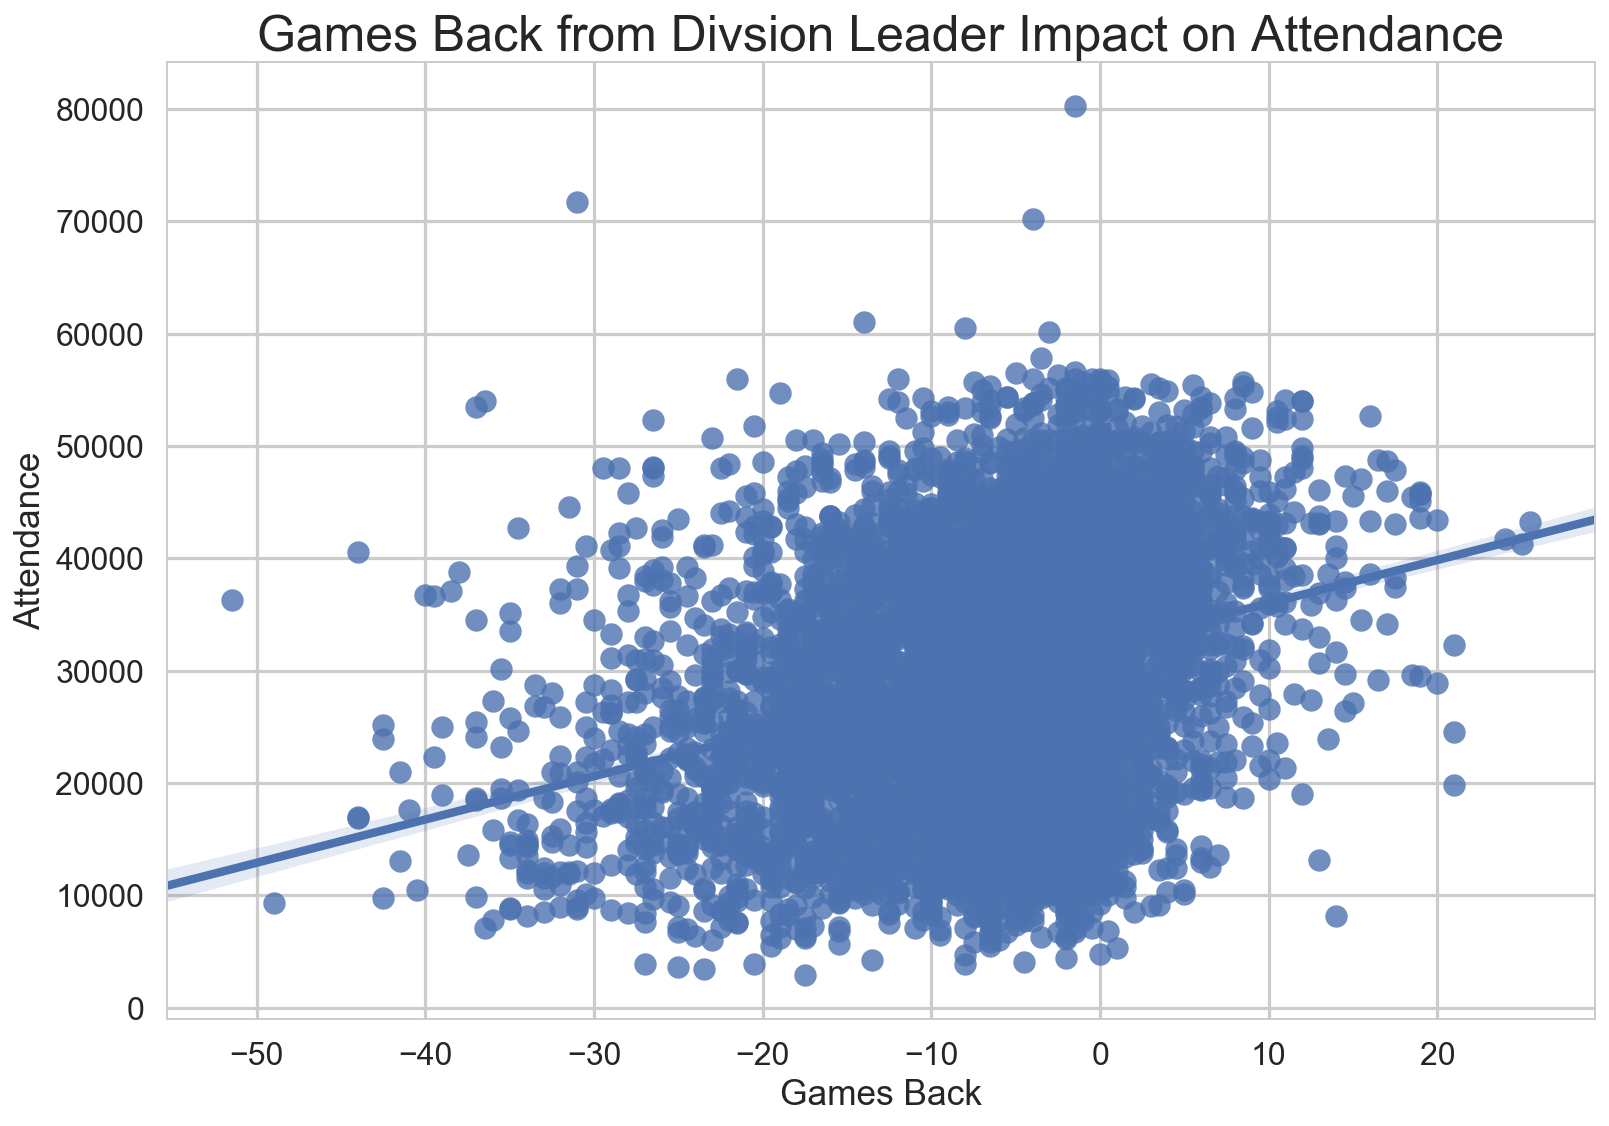

In [161]:
sns.regplot(x='gb', y='attendance', data=all_teams.sample(frac=.1))
plt.title('Games Back from Divsion Leader Impact on Attendance', fontsize=25)
plt.xlabel('Games Back')
plt.ylabel('Attendance')
plt.savefig('../images/gb-attendance-regplot.png')

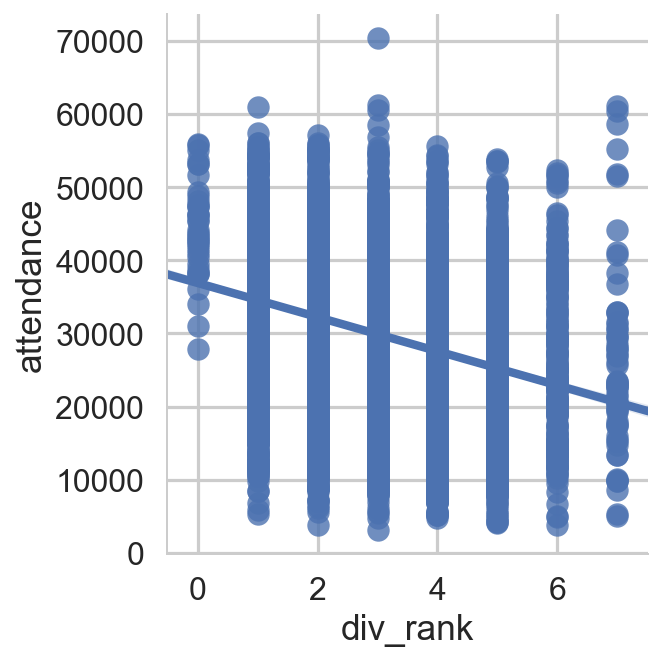

In [24]:
sns.lmplot(x='div_rank', y='attendance', data=all_teams.sample(frac=.1))

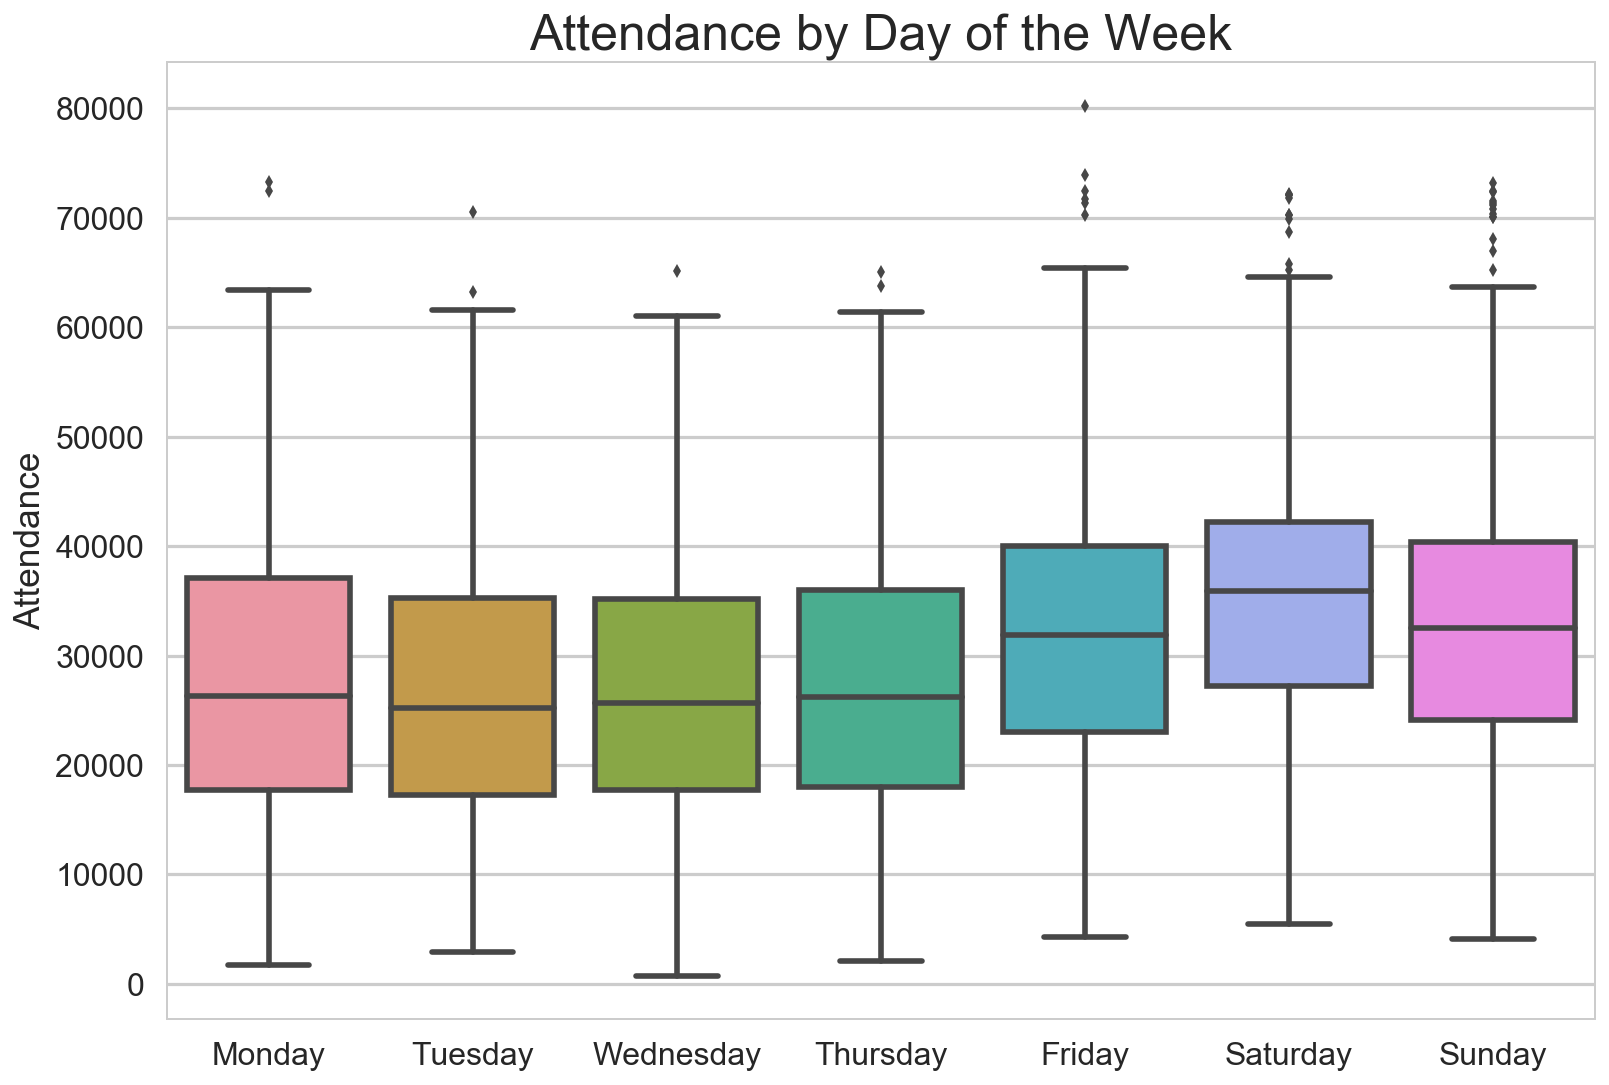

In [162]:
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.boxplot(x='weekday_name', y='attendance', data=all_teams, order=order)
plt.title('Attendance by Day of the Week', fontsize=25)
plt.xlabel('')
plt.ylabel('Attendance')
plt.savefig('../images/dayofweek-boxplot.png')

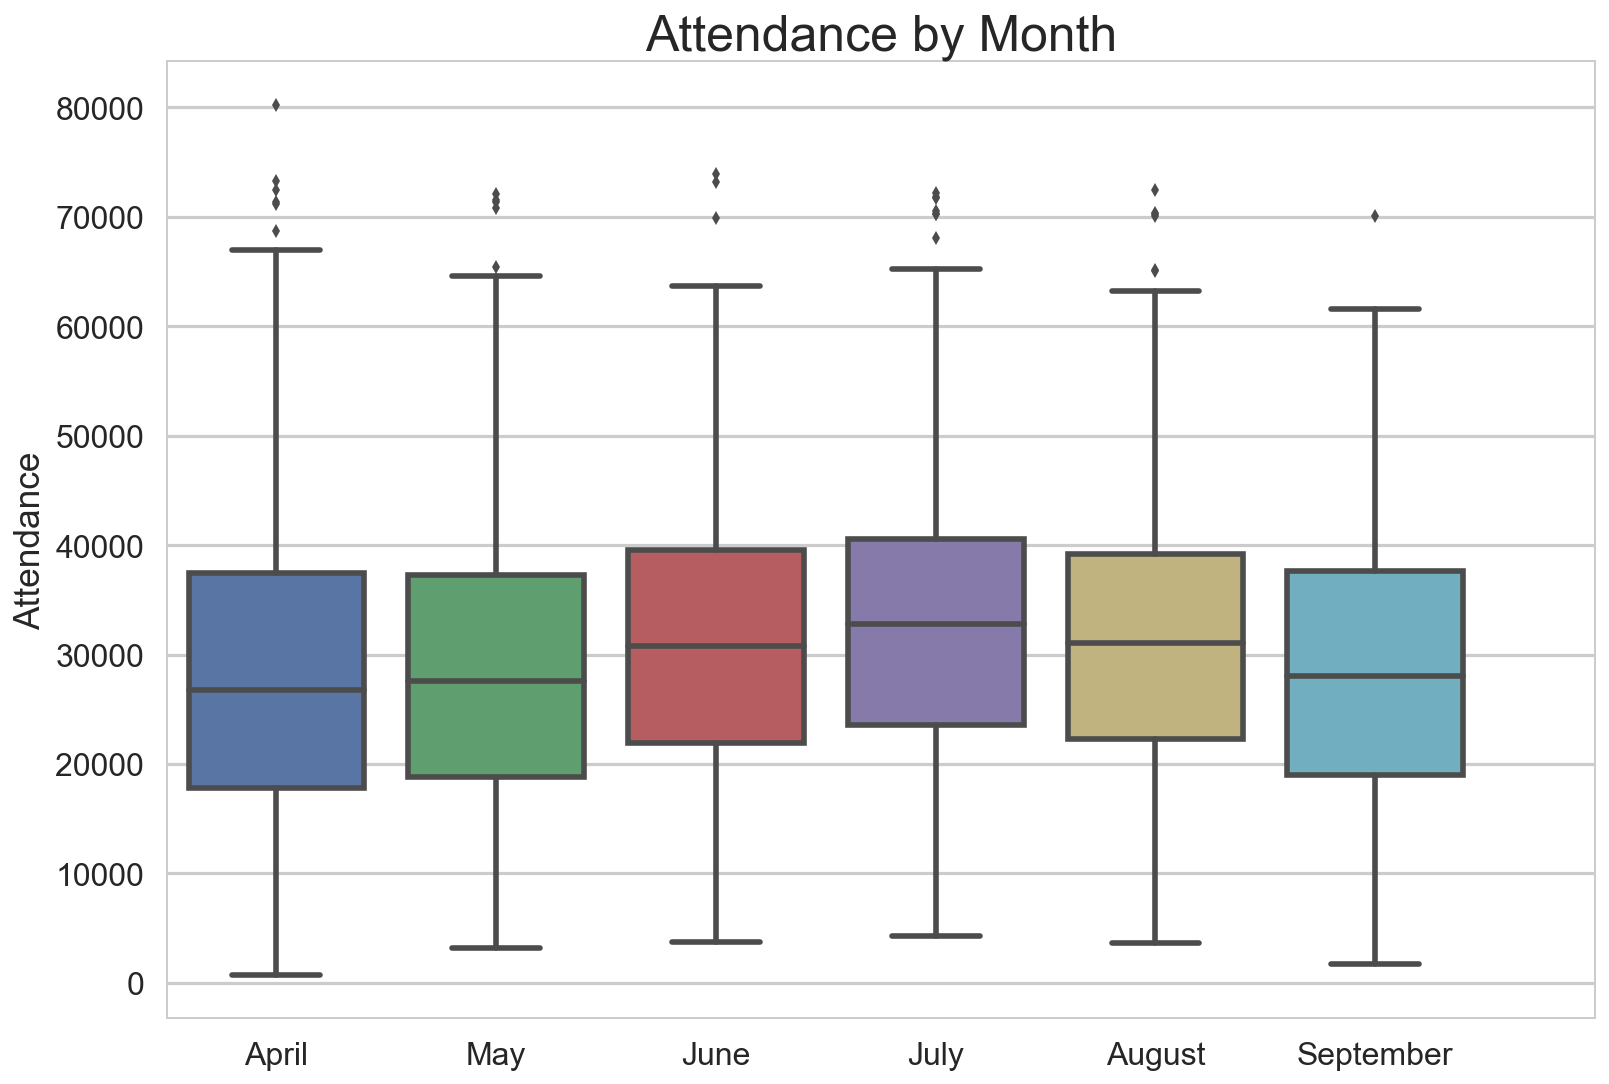

In [163]:
sns.boxplot(x='month', y='attendance', data=all_teams[(all_teams.month != 3) & (all_teams.month != 10)])
plt.title('Attendance by Month', fontsize=25)
plt.xlabel('')
plt.ylabel('Attendance')
plt.xticks(range(0,7), ['April', 'May', 'June', 'July', 'August', 'September'])
plt.savefig('../images/month-boxplot.png')

In [27]:
all_teams.describe()

div_rank            gb                    time    attendance  \
count  62415.000000  62415.000000                   62415  62415.000000   
mean       3.021005     -6.664416  0 days 02:56:22.434991  29727.469454   
std        1.556652      8.839055  0 days 00:27:21.655628  11391.712381   
min        0.000000    -52.000000         0 days 01:14:00    746.000000   
25%        2.000000    -11.500000         0 days 02:38:00  20546.500000   
50%        3.000000     -5.000000         0 days 02:53:00  29855.000000   
75%        4.000000     -1.000000         0 days 03:10:00  38804.500000   
max        7.000000     29.000000         0 days 07:06:00  80227.000000   

             streak  double_header       runs_pg       runs_ma  \
count  62415.000000   62415.000000  62415.000000  62415.000000   
mean       0.136682       0.016326      4.586164      4.587114   
std        2.552386       0.126728      0.857838      1.572443   
min      -15.000000       0.000000      0.000000      0.000000   
25%       -1.000000       0.000000      4.147059      3.600000   
50%        1.000000       0.000000      4.561905      4.400000   
75%        2.000000       0.000000      5.020906      5.600000   
max       19.000000       1.000000     16.000000     16.000000   

       runs_allowed_ma      ten_game   opening_day   total_games  \
count     62415.000000  62415.000000  62415.000000  62415.000000   
mean          4.582735      0.456931      0.012625     79.444172   
std           1.511675      0.179771      0.111651     46.448793   
min           0.400000      0.000000      0.000000      0.000000   
25%           3.400000      0.300000      0.000000     39.000000   
50%           4.400000      0.500000      0.000000     79.000000   
75%           5.600000      0.600000      0.000000    119.000000   
max          12.800000      1.000000      1.000000    162.000000   

            win_pct    night_game          year         month           day  \
count  62415.000000  62415.000000  62415.000000  62415.000000  62415.000000   
mean       0.497467      0.679436   2003.449139      6.571689     15.853513   
std        0.113334      0.466697      7.668986      1.708079      8.858365   
min        0.000000      0.000000   1990.000000      3.000000      1.000000   
25%        0.440678      0.000000   1997.000000      5.000000      8.000000   
50%        0.500000      1.000000   2004.000000      7.000000     16.000000   
75%        0.558140      1.000000   2010.000000      8.000000     24.000000   
max        1.000000      1.000000   2016.000000     10.000000     31.000000   

            weekday      capacity  
count  62415.000000  62415.000000  
mean       3.191156  46889.292125  
std        1.977775   7520.666815  
min        0.000000  31042.000000  
25%        1.000000  41313.000000  
50%        3.000000  45757.000000  
75%        5.000000  50516.000000  
max        6.000000  76273.000000

In [28]:
all_teams[all_teams.attendance == min(all_teams.attendance)]
# wednesday day game with Clemens of the mound

date team opponent  div_rank   gb     time  attendance  streak  \
11791 1997-04-09  CHW      TOR         4 -1.5 03:05:00         746       1   

       double_header  runs_pg  runs_ma  runs_allowed_ma  ten_game  \
11791              0      6.2      6.2              7.4       0.4   

       opening_day  total_games  win_pct  night_game  year  month  day  \
11791            0            5      0.4           0  1997      4    9   

       weekday weekday_name            stadium  capacity  
11791        2    Wednesday  US Cellular Field     44321

In [29]:
all_teams[all_teams.attendance == max(all_teams.attendance)]

date team opponent  div_rank   gb     time  attendance  streak  \
17649 1993-04-09  COL      MON         6 -1.5 02:42:00       80227      -2   

       double_header  runs_pg  runs_ma  runs_allowed_ma  ten_game  \
17649              0      0.5      0.5              7.4       0.0   

       opening_day  total_games  win_pct  night_game  year  month  day  \
17649            1            2      0.0           0  1993      4    9   

       weekday weekday_name            stadium  capacity  
17649        4       Friday  Mile High Stadium     76273

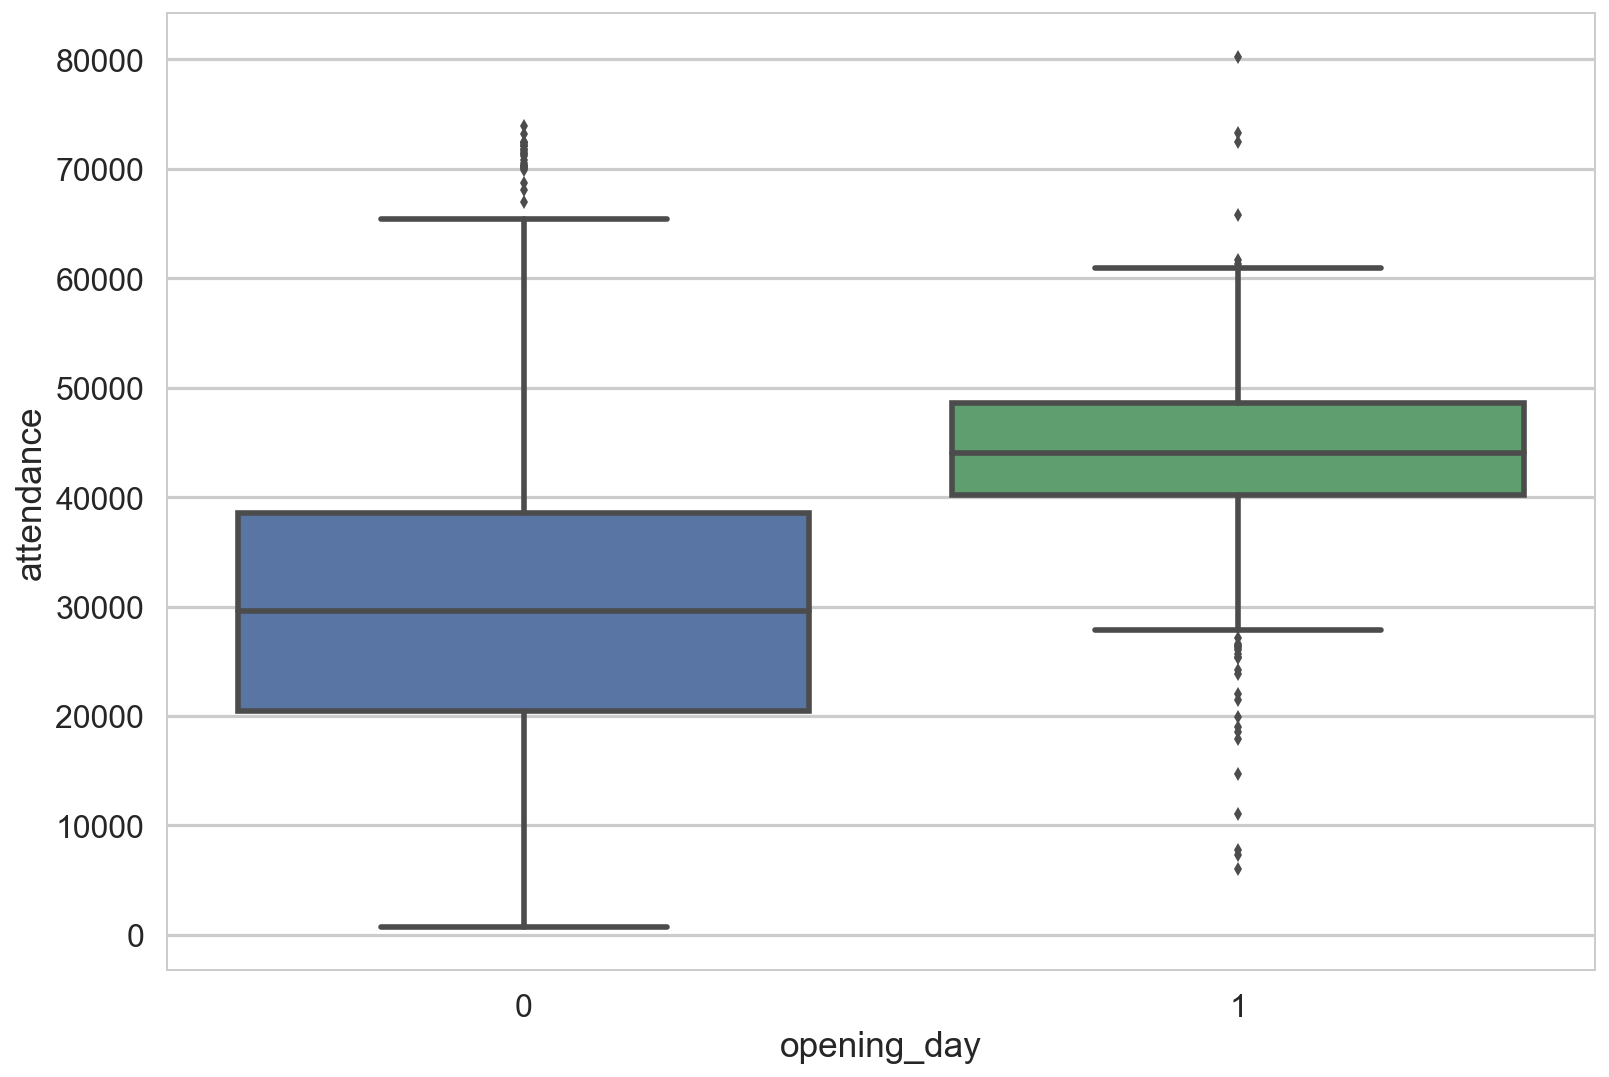

In [30]:
sns.boxplot(x='opening_day', y='attendance', data=all_teams)

### Plotting Yearly Data

In [31]:
yearly.sort_values('attendance').head(10)

team  year               stadium  capacity           team_name  \
456  MON  2001       Olympic Stadium     45757      Montreal Expos   
459  MON  2004       Olympic Stadium     45757      Montreal Expos   
454  MON  1999       Olympic Stadium     45757      Montreal Expos   
457  MON  2002       Olympic Stadium     45757      Montreal Expos   
283  FLA  2002      Sun Life Stadium     36331     Florida Marlins   
573  PIT  1995  Three Rivers Stadium     47952  Pittsburgh Pirates   
453  MON  1998       Olympic Stadium     45757      Montreal Expos   
455  MON  2000       Olympic Stadium     45757      Montreal Expos   
446  MON  1991       Olympic Stadium     45757      Montreal Expos   
599  SDP  1994      Qualcomm Stadium     46510    San Diego Padres   

       division    G  win_pct    gb  playoffs  attendance  bat_age  pitch_age  \
456     NL East  162    0.420  20.0         0      642745     27.6       27.4   
459     NL East  162    0.414  29.0         0      749550     27.5       26.5   
454     NL East  162    0.420  35.0         0      773277     25.9       25.5   
457     NL East  162    0.512  19.0         0      812045     28.2       27.7   
283     NL East  162    0.488  23.0         0      813118     28.4       26.1   
573  NL Central  144    0.403  27.0         0      905517     28.3       26.4   
453     NL East  162    0.401  41.0         0      914909     25.9       25.7   
455     NL East  162    0.414  28.0         0      926272     26.2       26.1   
446     NL East  161    0.441  26.5         0      934742     27.7       28.4   
599     NL West  117    0.402  12.5         0      953857     27.2       26.8   

      top_player  WAR  num_home_games    avg_att_pg  
456    J.Vazquez  6.3            81.0   7935.123457  
459  L.Hernandez  5.8            80.0   9369.375000  
454   V.Guerrero  4.4            81.0   9546.629630  
457   V.Guerrero  7.0            81.0  10025.246914  
283    A.Burnett  4.0            81.0  10038.493827  
573     D.Neagle  4.5            70.0  12935.957143  
453   V.Guerrero  7.4            81.0  11295.172840  
455   V.Guerrero  5.9            81.0  11435.456790  
446   D.Martinez  5.8            67.0  13951.373134  
599      T.Gwynn  4.2            57.0  16734.333333

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

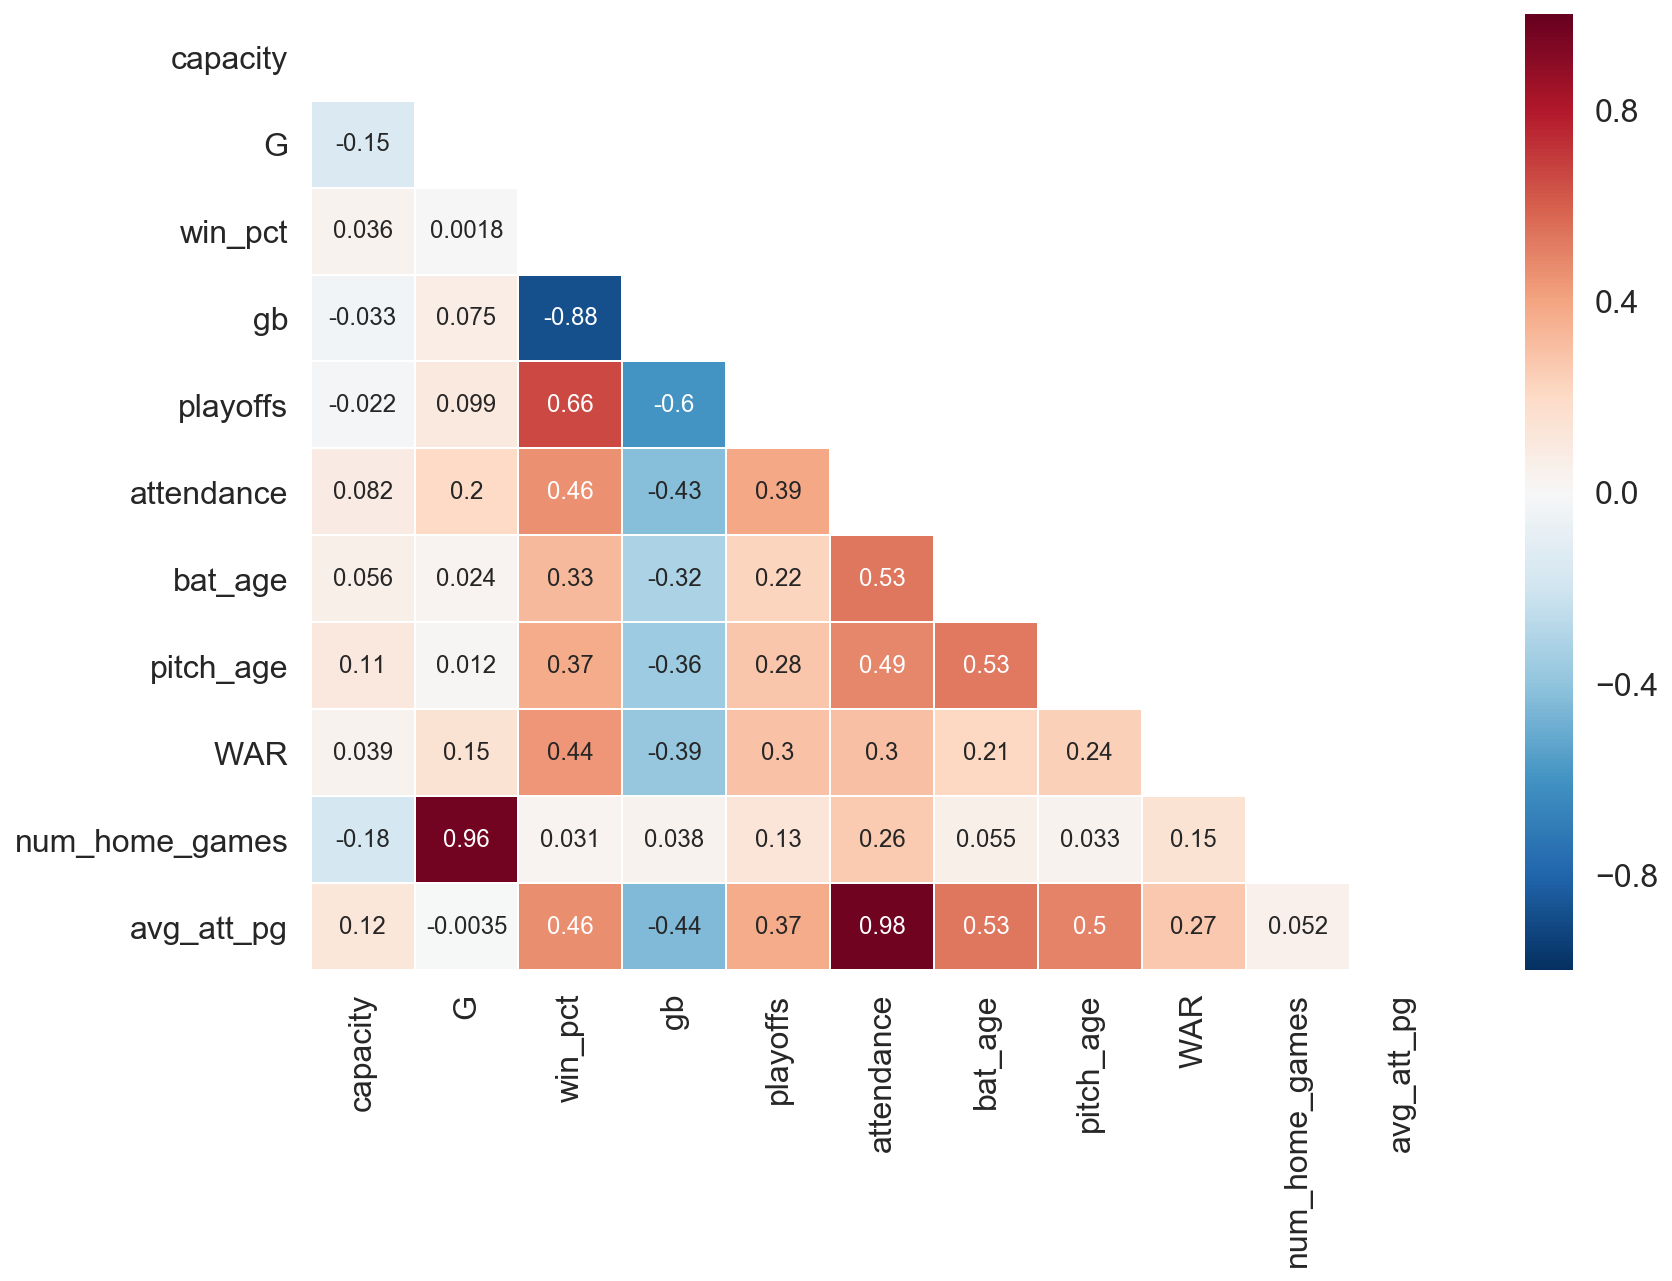

In [32]:
corr = yearly.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 12})
plt.xticks(rotation=90)

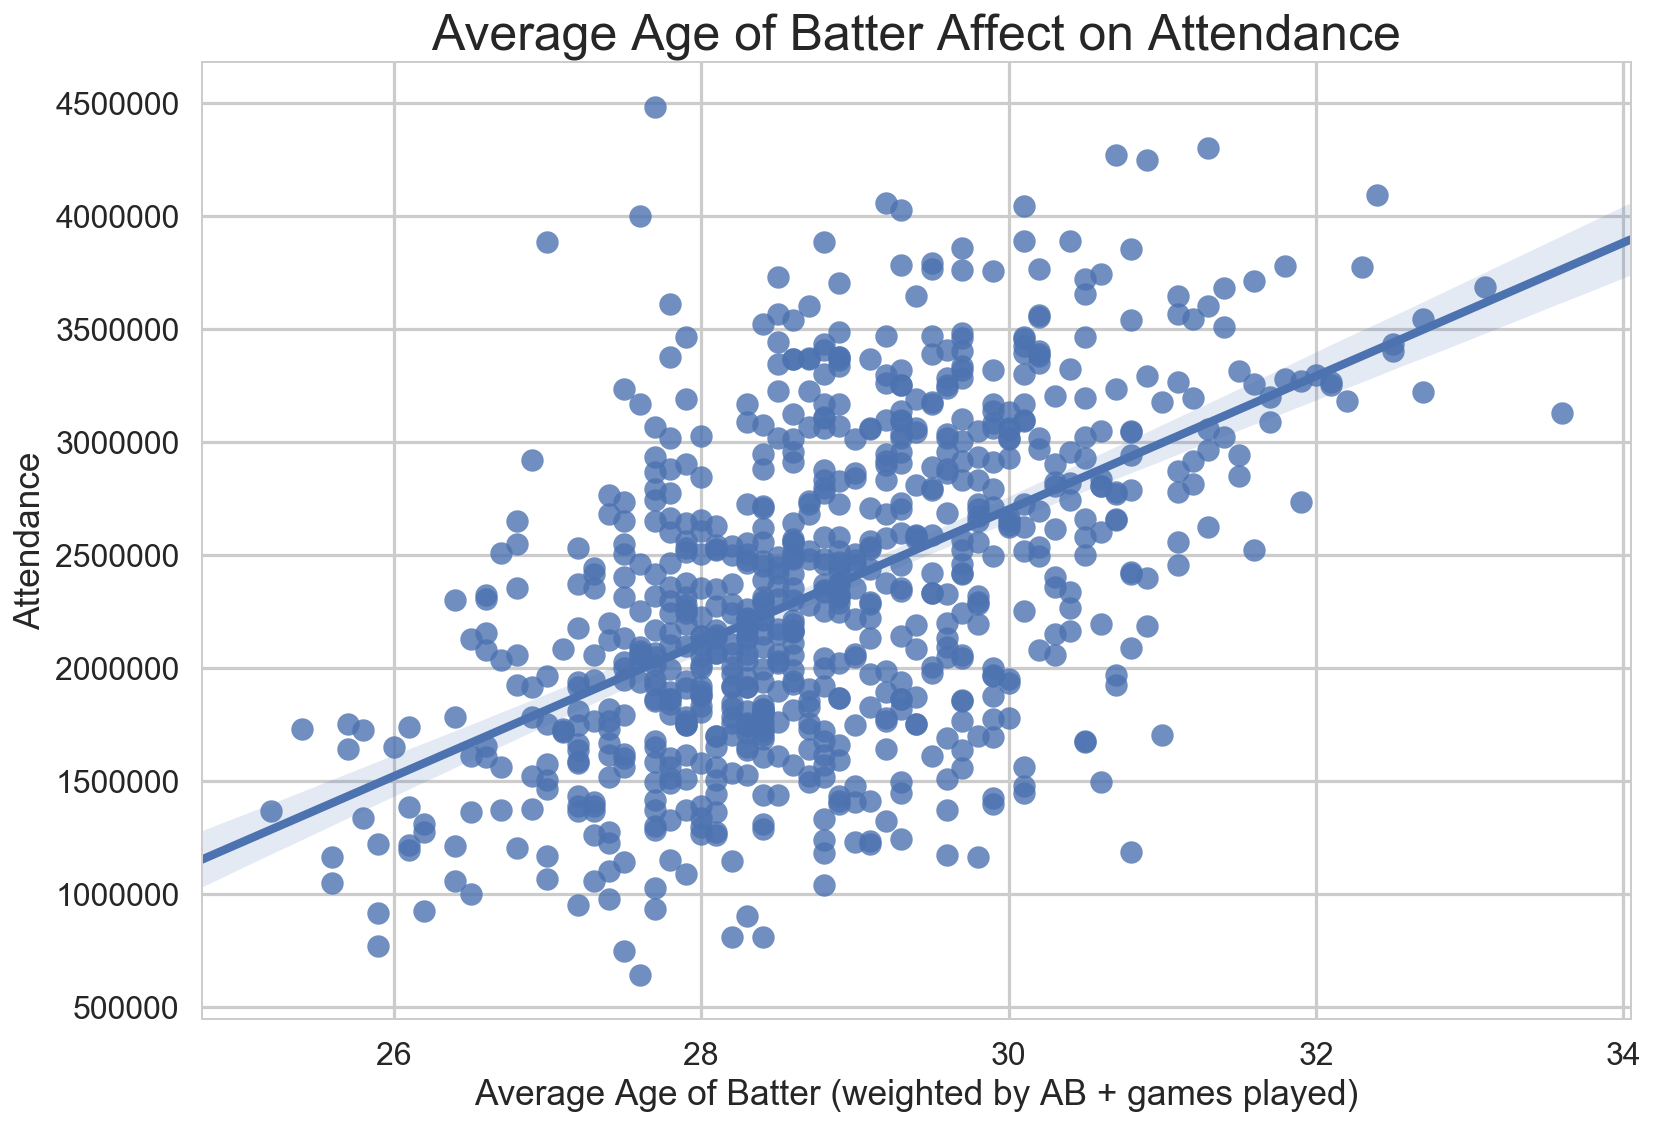

In [164]:
sns.regplot(x='bat_age', y='attendance', data=yearly)
plt.title('Average Age of Batter Affect on Attendance', fontsize=25)
plt.ylabel('Attendance')
plt.xlabel('Average Age of Batter (weighted by AB + games played)')
plt.savefig('../images/batage-regplot.png')

In [34]:
yearly[(yearly.bat_age < 26) | (yearly.bat_age > 32)].sort_values('bat_age')

team  year            stadium  capacity             team_name    division  \
280  FLA  1999   Sun Life Stadium     35521       Florida Marlins     NL East   
279  FLA  1998   Sun Life Stadium     42531       Florida Marlins     NL East   
287  FLA  2006   Sun Life Stadium     36331       Florida Marlins     NL East   
197  CLE  1991  Cleveland Stadium     74483     Cleveland Indians     AL East   
448  MON  1993    Olympic Stadium     45757        Montreal Expos     NL East   
317  HOU  2014   Minute Maid Park     42060        Houston Astros     AL West   
151  CHW  1999  US Cellular Field     44321     Chicago White Sox  AL Central   
341  KCR  2011   Kauffman Stadium     37903    Kansas City Royals  AL Central   
453  MON  1998    Olympic Stadium     45757        Montreal Expos     NL East   
454  MON  1999    Olympic Stadium     45757        Montreal Expos     NL East   
198  CLE  1992  Cleveland Stadium     74483     Cleveland Indians     AL East   
662  SFG  2003          AT&T Park     41503  San Francisco Giants     NL West   
661  SFG  2002          AT&T Park     41059  San Francisco Giants     NL West   
664  SFG  2005          AT&T Park     41584  San Francisco Giants     NL West   
501  NYY  2004   Yankee Stadium I     57478      New York Yankees     AL East   
502  NYY  2005   Yankee Stadium I     56936      New York Yankees     AL East   
63   BAL  1999        Oriole Park     48079     Baltimore Orioles     AL East   
511  NYY  2014  Yankee Stadium II     49642      New York Yankees     AL East   
666  SFG  2007          AT&T Park     41915  San Francisco Giants     NL West   
509  NYY  2012  Yankee Stadium II     50291      New York Yankees     AL East   
62   BAL  1998        Oriole Park     48079     Baltimore Orioles     AL East   
665  SFG  2006          AT&T Park     41606  San Francisco Giants     NL West   

       G  win_pct    gb  playoffs  attendance  bat_age  pitch_age  \
280  162    0.395  39.0         0     1369421     25.2       26.0   
279  162    0.333  52.0         0     1730384     25.4       24.5   
287  162    0.481  19.0         0     1164134     25.6       25.9   
197  162    0.352  34.0         0     1051863     25.6       26.8   
448  163    0.580   3.0         0     1641437     25.7       27.9   
317  162    0.432  28.0         0     1751829     25.7       27.9   
151  162    0.466  21.5         0     1338851     25.8       26.4   
341  162    0.438  24.0         0     1724450     25.8       26.4   
453  162    0.401  41.0         0      914909     25.9       25.7   
454  162    0.420  35.0         0      773277     25.9       25.5   
198  162    0.469  20.0         0     1224094     25.9       27.0   
662  161    0.621   0.0         1     3264898     32.1       28.6   
661  162    0.590   2.5         1     3253203     32.1       29.2   
664  162    0.463   7.0         0     3181023     32.2       30.0   
501  162    0.623   0.0         1     3775292     32.3       32.9   
502  162    0.586   0.0         1     4090696     32.4       34.2   
63   162    0.481  20.0         0     3433150     32.5       30.1   
511  162    0.519  12.0         0     3401624     32.5       29.3   
666  162    0.438  19.0         0     3223215     32.7       27.3   
509  162    0.586   0.0         1     3542406     32.7       30.3   
62   162    0.488  35.0         0     3684650     33.1       30.5   
665  161    0.472  11.5         0     3130313     33.6       28.7   

      top_player   WAR  num_home_games    avg_att_pg  
280  A.Fernandez   3.4            78.0  17556.679487  
279     M.Kotsay   3.9            79.0  21903.594937  
287    M.Cabrera   5.8            81.0  14372.024691  
197   G.Swindell   3.8            79.0  13314.721519  
448    M.Grissom   5.2            81.0  20264.654321  
317     J.Altuve   6.1            81.0  21627.518519  
151    M.Ordonez   5.8            76.0  17616.460526  
341     A.Gordon   7.2            81.0  21289.506173  
453   V.Guerrero   7.4            81.0  11295.172840  
45

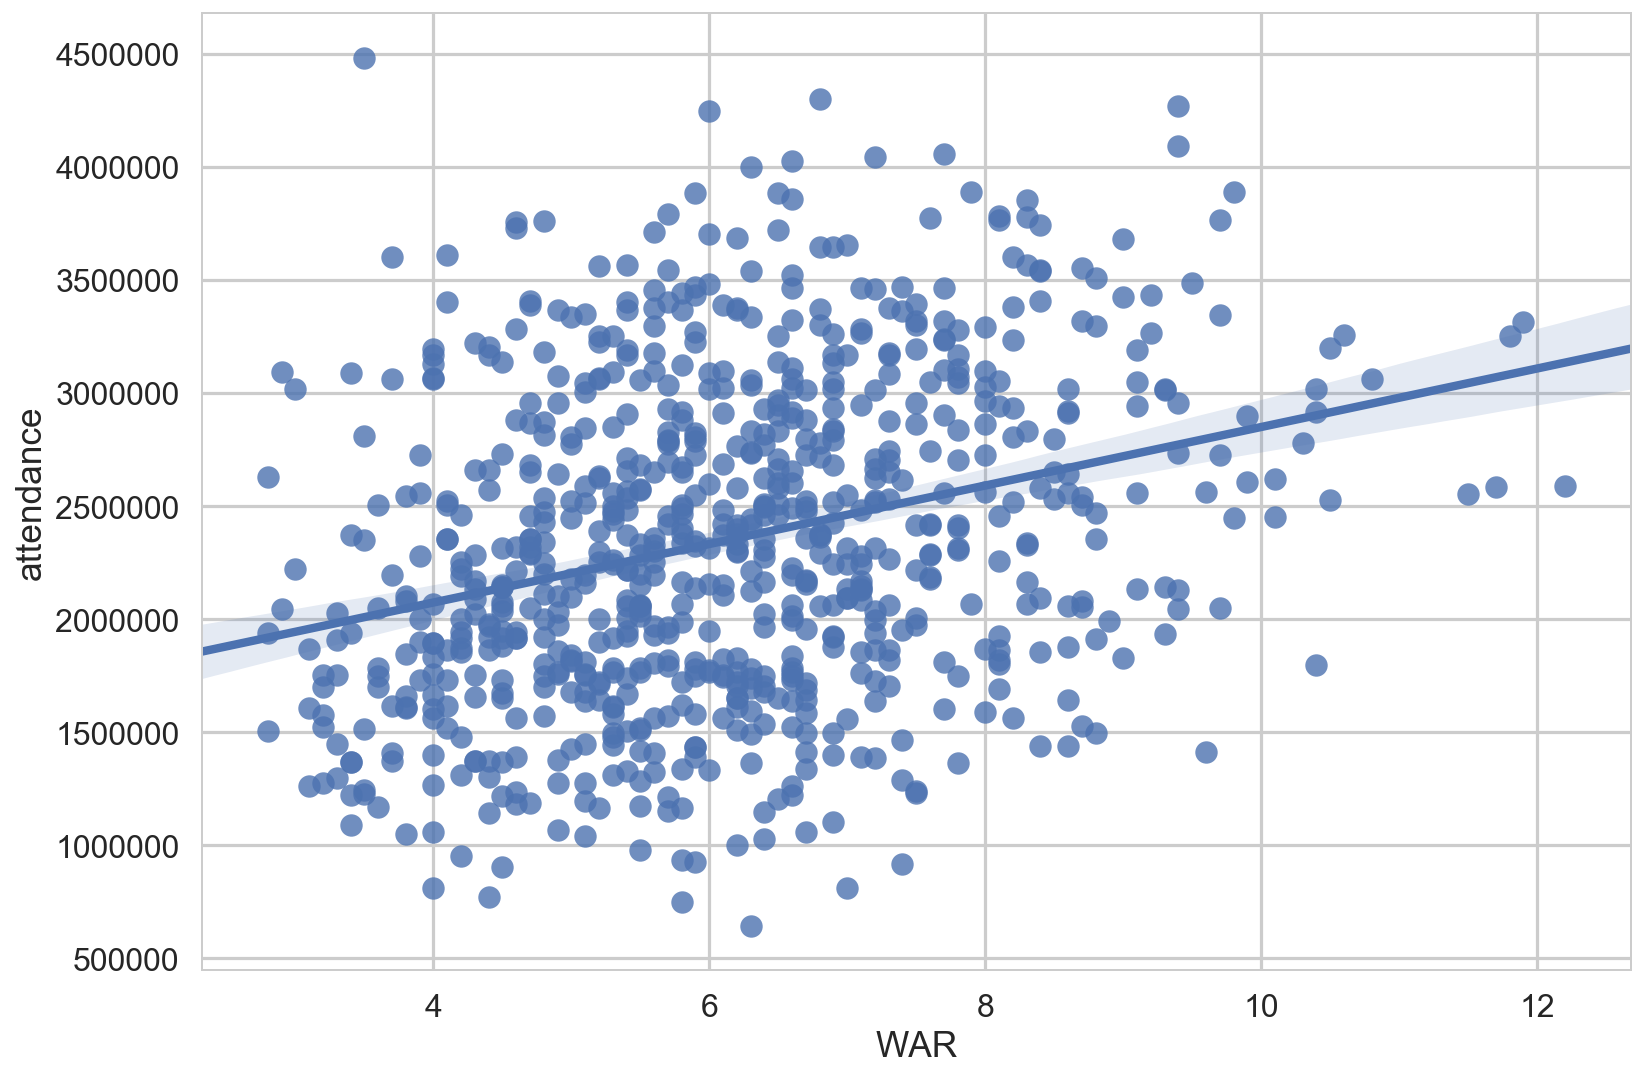

In [35]:
sns.regplot(x='WAR', y='attendance', data=yearly)

In [36]:
yearly[yearly.WAR > 10].sort_values('WAR')

team  year             stadium  capacity                      team_name  \
172  CIN  1993  Riverfront Stadium     52952                Cincinnati Reds   
786  WSN  2015      Nationals Park     41418           Washington Nationals   
126  CHC  2001       Wrigley Field     39059                   Chicago Cubs   
339  KCR  2009    Kauffman Stadium     37903             Kansas City Royals   
358  LAA  2016       Angel Stadium     45493  Los Angeles Angels of Anaheim   
632  SEA  2000        Safeco Field     47116               Seattle Mariners   
12   ARI  2002         Chase Field     49033           Arizona Diamondbacks   
81   BOS  1990         Fenway Park     34182                 Boston Red Sox   
663  SFG  2004           AT&T Park     41503           San Francisco Giants   
354  LAA  2012       Angel Stadium     45957  Los Angeles Angels of Anaheim   
55   BAL  1991    Memorial Stadium     53371              Baltimore Orioles   
91   BOS  2000         Fenway Park     33871                 Boston Red Sox   
661  SFG  2002           AT&T Park     41059           San Francisco Giants   
660  SFG  2001           AT&T Park     41059           San Francisco Giants   
756  TOR  1997       Rogers Centre     50516              Toronto Blue Jays   

       division    G  win_pct    gb  playoffs  attendance  bat_age  pitch_age  \
172     NL West  162    0.451  31.0         0     2453232     28.4       27.9   
786     NL East  162    0.512   7.0         0     2619843     28.4       28.6   
126  NL Central  162    0.543   5.0         0     2779465     30.7       29.8   
339  AL Central  162    0.401  21.5         0     1797891     27.8       28.7   
358     AL West  162    0.457  21.0         0     3016142     28.5       28.4   
632     AL West  162    0.562   0.5         1     2914624     31.2       29.3   
12      NL West  162    0.605   0.0         1     3198977     31.7       31.7   
81      AL East  162    0.543   0.0         1     2528986     29.1       30.6   
663     NL West  162    0.562   2.0         0     3256854     31.6       30.1   
354     AL West  162    0.549   5.0         0     3061770     28.8       30.1   
55      AL East  162    0.414  24.0         0     2552753     28.3       27.4   
91      AL East  162    0.525   2.5         0     2585895     29.4       30.2   
661     NL West  162    0.590   2.5         1     3253203     32.1       29.2   
660     NL West  162    0.556   2.0         0     3311958     31.5       29.2   
756     AL East  162    0.469  22.0         0     2589297     29.5       28.8   

      top_player   WAR  num_home_games    avg_att_pg  
172       J.Rijo  10.1            79.0  31053.569620  
786     B.Harper  10.1            81.0  32343.740741  
126       S.Sosa  10.3            79.0  35183.101266  
339    Z.Greinke  10.4            80.0  22473.637500  
358      M.Trout  10.4            81.0  37236.320988  
632  A.Rodriguez  10.4            81.0  35983.012346  
12     R.Johnson  10.5            81.0  39493.543210  
81     R.Clemens  10.5            80.0  31612.325000  
663      B.Bonds  10.6            81.0  40208.074074  
354      M.Trout  10.8            81.0  37799.629630  
55      C.Ripken  11.5            79.0  32313.329114  
91    P.Martinez  11.7            81.0  31924.629630  
661      B.Bonds  11.8            81.0  40163.000000  
660      B.Bonds  11.9            81.0  40888.370370  
756    R.Clemens  12.2            81.0  31966.629630

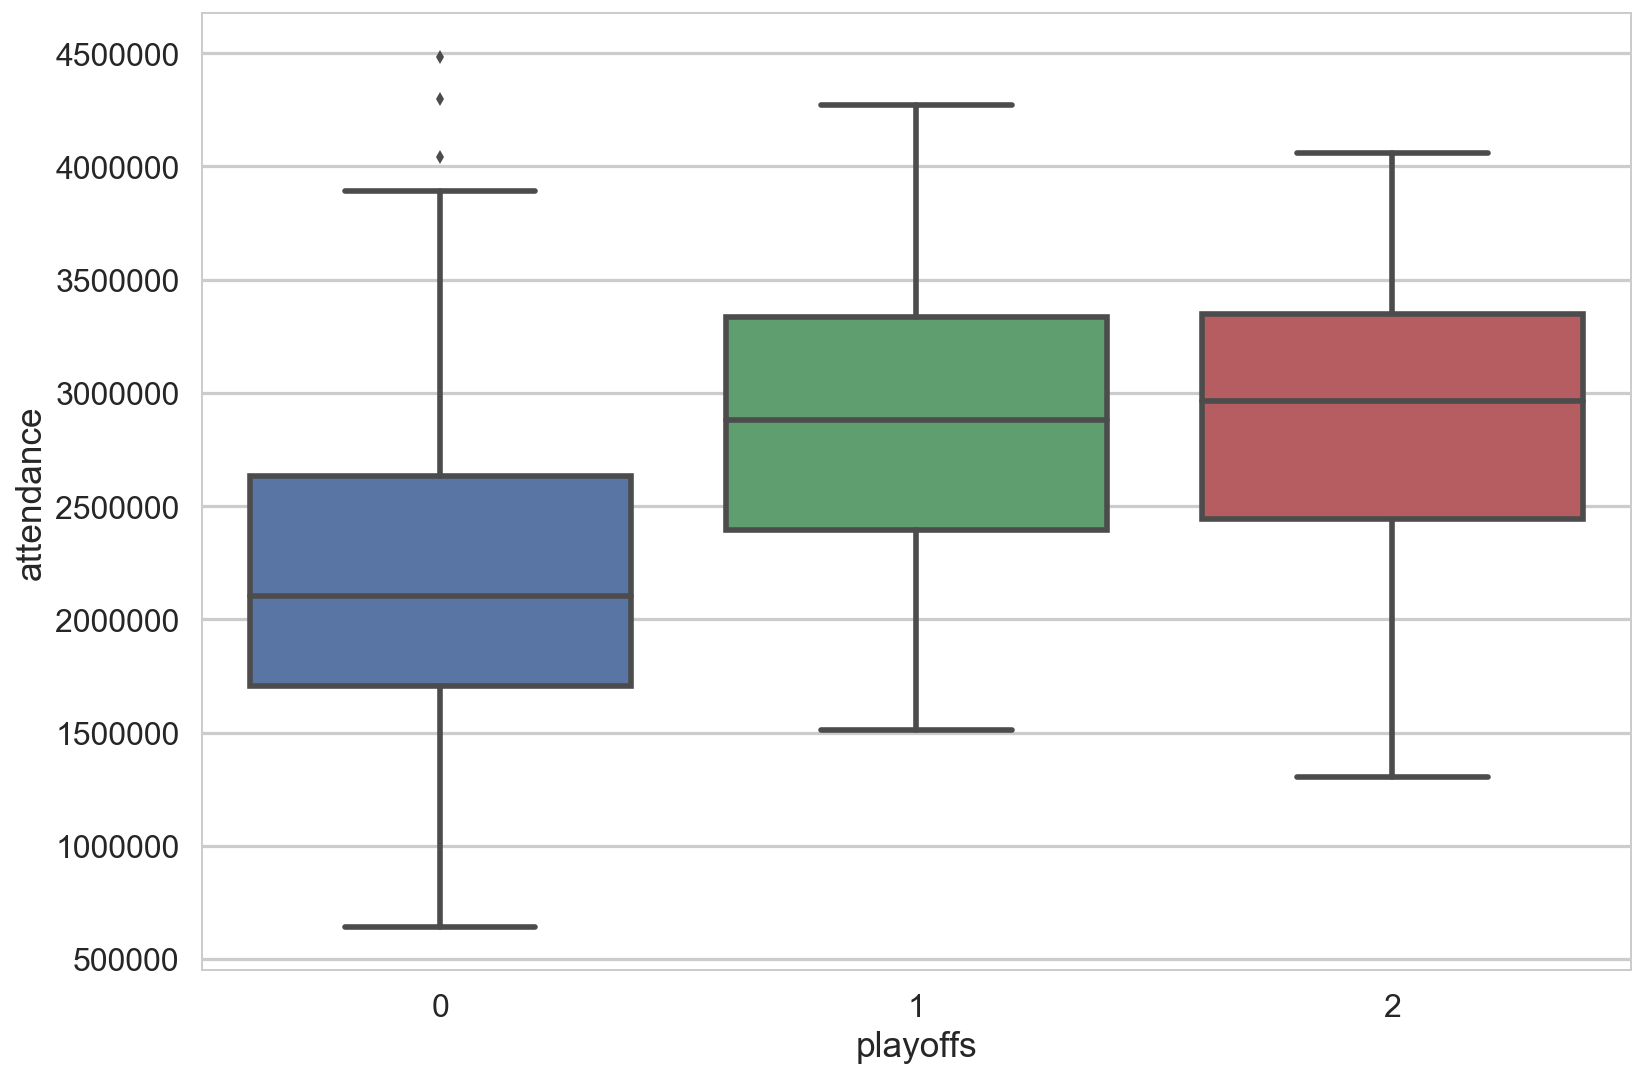

In [37]:
sns.boxplot(x='playoffs', y='attendance', data=yearly)

#### Adding division, bat_age, pitch_age, WAR into all_teams df

In [38]:
all_teams = all_teams.merge(yearly[['team', 'year', 'bat_age', 'pitch_age', 'division']],
                            on=['team', 'year'])
all_teams = all_teams.merge(yearly[['team', 'year', 'division']], left_on=['opponent', 'year'],
                            right_on=['team', 'year'])

In [39]:
%time all_teams['division_game'] = [1 if all_teams.loc[i].division_x == all_teams.loc[i].division_y else 0 for i in range(0,len(all_teams))]
all_teams.drop(['division_x', 'team_y', 'division_y'], axis=1, inplace=True)

CPU times: user 30.6 s, sys: 214 ms, total: 30.8 s
Wall time: 31 s


In [40]:
all_teams.sample(frac=.1).head(10)

date team_x opponent  div_rank    gb     time  attendance  streak  \
51060 1995-07-09    CLE      SEA         1  12.0 02:50:00       41897       1   
29161 2013-06-11    MIN      PHI         4  -7.5 02:31:00       30104      -2   
49703 1993-09-09    TOR      OAK         1   0.5 03:18:00       50518      -5   
32206 2015-06-17    CLE      CHC         4  -7.0 03:06:00       15572       1   
35163 1990-05-30    ATL      MON         4 -13.0 03:24:00       10372      -1   
60674 2016-06-09    NYY      LAA         4  -6.5 02:58:00       34971       3   
57442 2011-08-17    KCR      NYY         5 -15.5 03:02:00       22435      -4   
57992 2012-08-08    CLE      MIN         3 -10.5 02:28:00       18805     -11   
17520 2005-04-23    COL      LAD         5  -7.0 03:15:00       30272       1   
19497 2006-07-14    SDP      ATL         1   2.0 04:23:00       42869       5   

       double_header   runs_pg  runs_ma  runs_allowed_ma  ten_game  \
51060              0  5.757576      5.2              3.2       0.7   
29161              0  4.200000      2.4              5.2       0.4   
49703              0  5.071429      2.4              5.2       0.4   
32206              0  4.206349      3.6              3.2       0.4   
35163              0  3.952381      5.4              4.2       0.4   
60674              0  3.983051      6.4              4.0       0.5   
57442              0  4.349593      4.4              5.6       0.2   
57992              0  4.236364      3.8              9.4       0.0   
17520              0  5.187500      6.0              3.4       0.4   
19497              0  4.465909      5.8              3.8       0.6   

       opening_day  total_games   win_pct  night_game  year  month  day  \
51060            0           66  0.696970           0  1995      7    9   
29161            0           60  0.450000           1  2013      6   11   
49703            0          140  0.557143           1  1993      9    9   
32206            0           63  0.476190           1  2015      6   17   
35163            0           42  0.404762           1  1990      5   30   
60674            0           59  0.491525           1  2016      6    9   
57442            0          123  0.406504           1  2011      8   17   
57992            0          110  0.454545           0  2012      8    8   
17520            0           16  0.312500           1  2005      4   23   
19497            0           88  0.545455           1  2006      7   14   

       weekday weekday_name                stadium  capacity  bat_age  \
51060        6       Sunday      Progressive Field     42865     29.0   
29161        1      Tuesday           Target Field     39021     28.3   
49703        3     Thursday          Rogers Centre     50516     29.2   
32206        2    Wednesday      Progressive Field     36856     28.0   
35163        2    Wednesday  Fulton County Stadium     52007     27.4   
60674        3     Thursday      Yankee Stadium II     49469     29.9   
57442        2    Wednesday       Kauffman Stadium     37903     25.8   
57992        2    Wednesday      Progressive Field     43429     27.8   
17520        5     Saturday            Coors Field     50445     27.2   
19497        4       Friday             Petco Park     42445     30.7   

       pitch_age  division_game  
51060       30.6              0  
29161       28.3              0  
49703       29.5              0  
32206       27.3              0  
35163       25.8              0  
60674       27.9              0  
57442       26.4              0  
57992       27.6              1  
17520       27.3              1  
19497       30.6              0

In [41]:
all_teams.dtypes

date                datetime64[ns]
team_x                      object
opponent                    object
div_rank                     int64
gb                         float64
time               timedelta64[ns]
attendance                   int64
streak                       int64
double_header                int64
runs_pg                    float64
runs_ma                    float64
runs_allowed_ma            float64
ten_game                   float64
opening_day                  int64
total_games                  int64
win_pct                    float64
night_game                   int64
year                        object
month                        int64
day                          int64
weekday                      int64
weekday_name                object
stadium                     object
capacity                     int64
bat_age                    float64
pitch_age                  float64
division_game                int64
dtype: object

In [42]:
all_teams.night_game.value_counts()

1    42407
0    20008
Name: night_game, dtype: int64

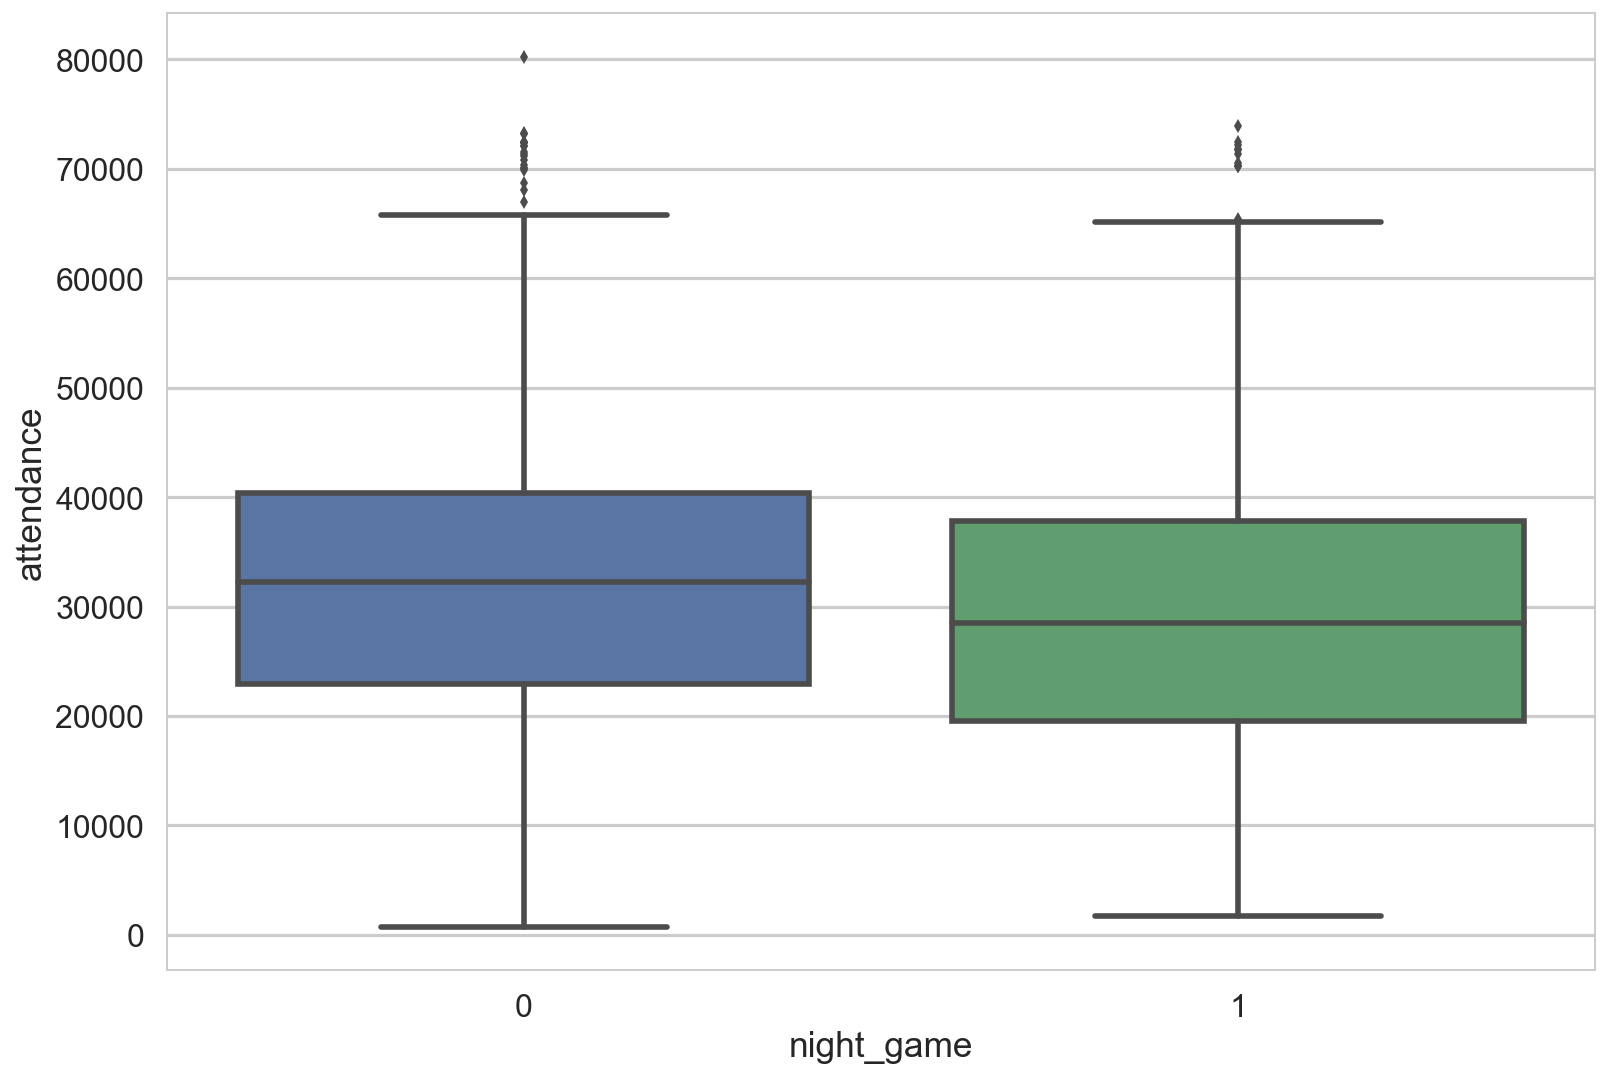

In [43]:
sns.boxplot(x='night_game', y='attendance', data=all_teams)

In [44]:
all_teams.division_game.value_counts()

0    35836
1    26579
Name: division_game, dtype: int64

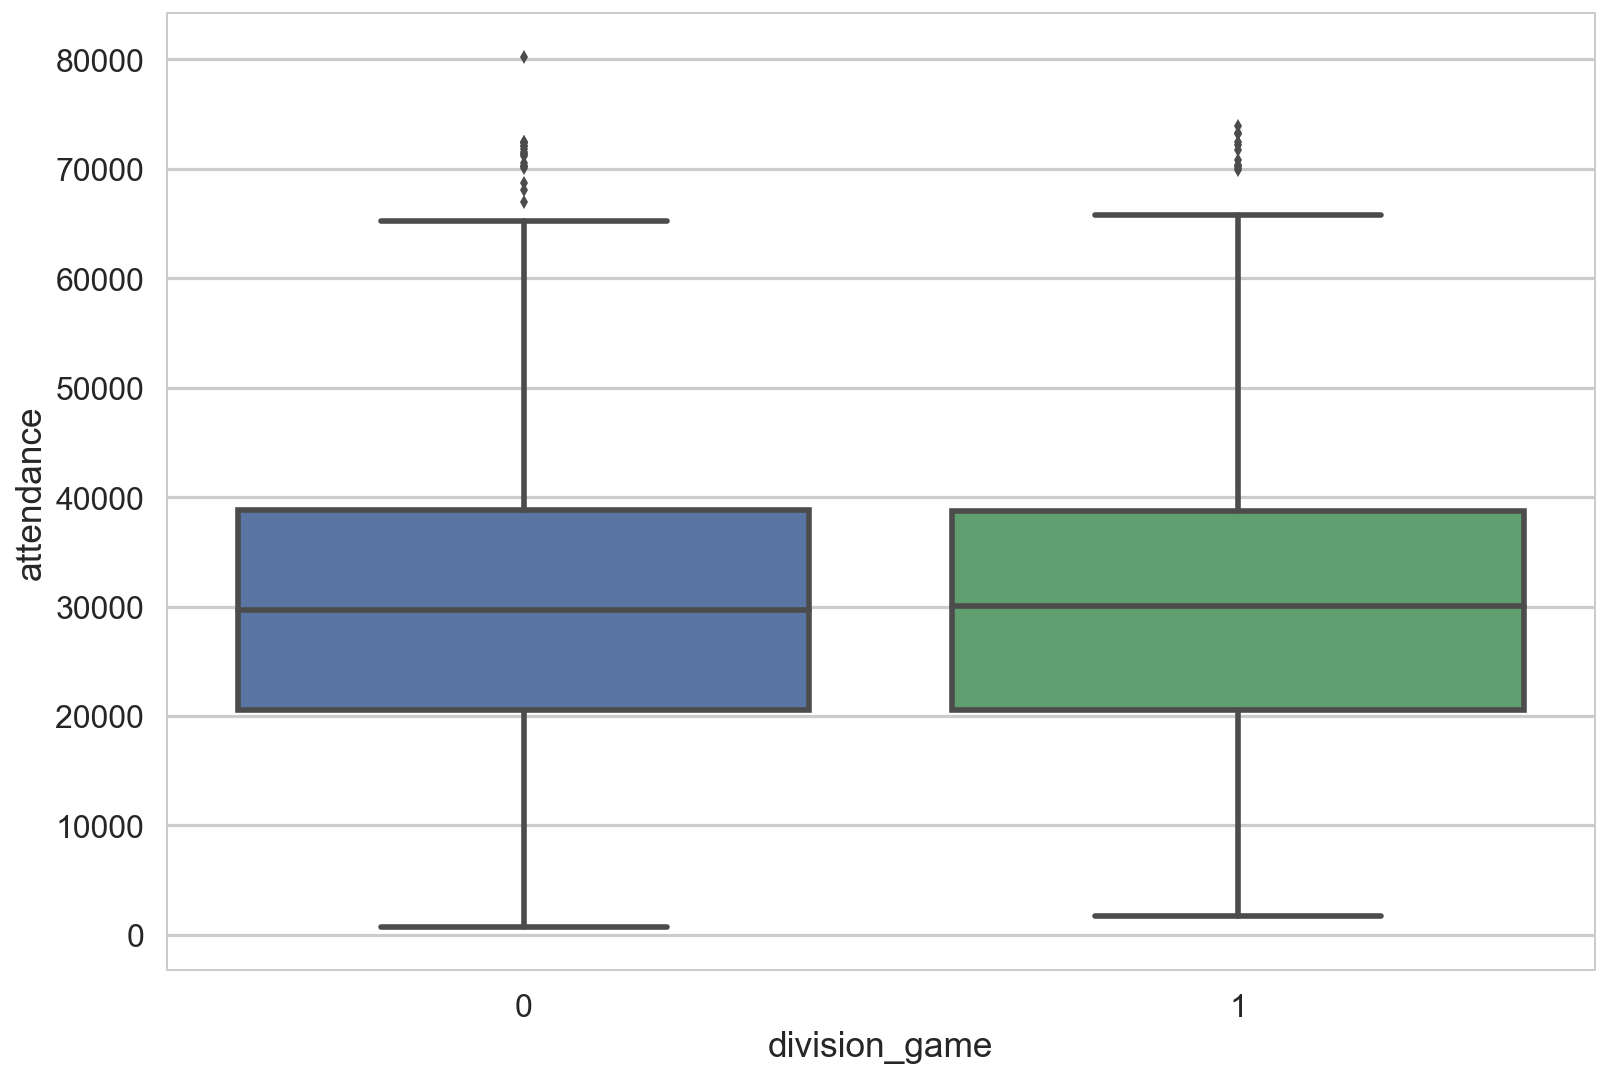

In [45]:
sns.boxplot(x='division_game', y='attendance', data=all_teams)

### Create CSV files

In [46]:
all_teams.to_csv('../data/all-teams-1990-2016.csv', index=False, encoding = 'utf-8')

In [47]:
for i in all_teams.team_x.unique():
    df = all_teams[all_teams.team_x == i]
    df.to_csv('../data/' + i + '-game-data.csv', index=False, encoding='utf-8')

In [48]:
yearly.to_csv('../data/yearly-team-data.csv', index=False, encoding='utf-8')

---

# Building Regression Models

In [172]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import time

In [173]:
all_teams = pd.read_csv('../data/all-teams-1990-2016.csv')

In [174]:
print all_teams.shape
print all_teams.isnull().sum()
print all_teams.dtypes
all_teams.tail(15)

(62415, 27)
date               0
team_x             0
opponent           0
div_rank           0
gb                 0
time               0
attendance         0
streak             0
double_header      0
runs_pg            0
runs_ma            0
runs_allowed_ma    0
ten_game           0
opening_day        0
total_games        0
win_pct            0
night_game         0
year               0
month              0
day                0
weekday            0
weekday_name       0
stadium            0
capacity           0
bat_age            0
pitch_age          0
division_game      0
dtype: int64
date                object
team_x              object
opponent            object
div_rank             int64
gb                 float64
time                object
attendance           int64
streak               int64
double_header        int64
runs_pg            float64
runs_ma            float64
runs_allowed_ma    float64
ten_game           float64
opening_day          int64
total_games          int64
win

date team_x opponent  div_rank    gb                       time  \
62400  1996-07-30    SDP      ATL         1   1.5  0 days 02:23:00.000000000   
62401  1996-07-31    SDP      ATL         1   1.5  0 days 02:39:00.000000000   
62402  1996-08-01    SDP      ATL         1   0.5  0 days 03:16:00.000000000   
62403  1996-04-24    SFG      ATL         3  -3.0  0 days 02:22:00.000000000   
62404  1996-04-25    SFG      ATL         3  -4.0  0 days 02:12:00.000000000   
62405  1996-07-25    SFG      ATL         4 -10.0  0 days 02:06:00.000000000   
62406  1996-07-26    SFG      ATL         4  -9.0  0 days 02:51:00.000000000   
62407  1996-07-27    SFG      ATL         4 -10.0  0 days 02:26:00.000000000   
62408  1996-07-28    SFG      ATL         4 -10.0  0 days 03:04:00.000000000   
62409  1996-04-26    STL      ATL         1   0.5  0 days 02:43:00.000000000   
62410  1996-04-27    STL      ATL         1   0.5  0 days 02:39:00.000000000   
62411  1996-04-29    STL      ATL         2  -0.5  0 days 02:41:00.000000000   
62412  1996-07-22    STL      ATL         1   3.0  0 days 03:11:00.000000000   
62413  1996-07-23    STL      ATL         1   2.0  0 days 02:22:00.000000000   
62414  1996-07-24    STL      ATL         1   2.0  0 days 02:22:00.000000000   

       attendance  streak  double_header   runs_pg  runs_ma  runs_allowed_ma  \
62400       24110       1              0  4.943925      6.8              5.8   
62401       24254       2              0  4.916667      6.4              4.8   
62402       24089      -1              0  4.908257      6.6              6.2   
62403       13296      -2              0  5.450000      6.6              7.8   
62404       12436      -3              0  5.333333      6.0              7.4   
62405       16871      -2              0  4.740000      4.6              6.2   
62406       17560       1              0  4.732673      4.0              5.6   
62407       38761      -1              0  4.696078      3.0              4.6   
62408       34525       1              0  4.718447      3.8              5.2   
62409       34598      -1              0  4.260870      5.0              7.4   
62410       20757      -2              0  4.125000      4.8              7.8   
62411       25452      -3              0  4.040000      5.2              7.6   
62412       36215       1              0  4.897959      5.2              3.8   
62413       35520      -1              0  4.909091      5.2              4.6   
62414       35411      -2              0  4.880000      4.6              4.0   

       ten_game  opening_day  total_games   win_pct  night_game  year  month  \
62400       0.6            0          107  0.532710           1  1996      7   
62401       0.6            0          108  0.537037           1  1996      7   
62402       0.6            0          109  0.532110           0  1996      8   
62403       0.3            0           20  0.500000           1  1996      4   
62404       0.3            0           21  0.476190           0  1996      4   
62405       0.1            0          100  0.430000           1  1996      7   
62406       0.2            0          101  0.435644           1  1996      7   
62407       0.2            0          102  0.431373           0  1996      7   
62408       0.3            0          103  0.436893           0  1996      7   
62409       0.4            0           23  0.521739           1  1996      4   
62410       0.4            0           24  0.500000           0  1996      4   
62411       0.3            0           25  0.480000           1  1996      4   
62412       0.7            0           98  0.551020           1  1996      7   
62413       0.6            0           99  0.545455           1  1996      7   
62414       0.5            0          100  0.540000           1  1996      7   

       day  weekday weekday_name                 stadium  capacity  bat_age  \
62400   30        1      Tuesday        Qualcomm Stadium     49639     30.9   
62401   31  

In [175]:
all_teams.date = pd.to_datetime(all_teams.date)
all_teams.drop(['date', 'time', 'weekday_name'], inplace=True, axis=1)

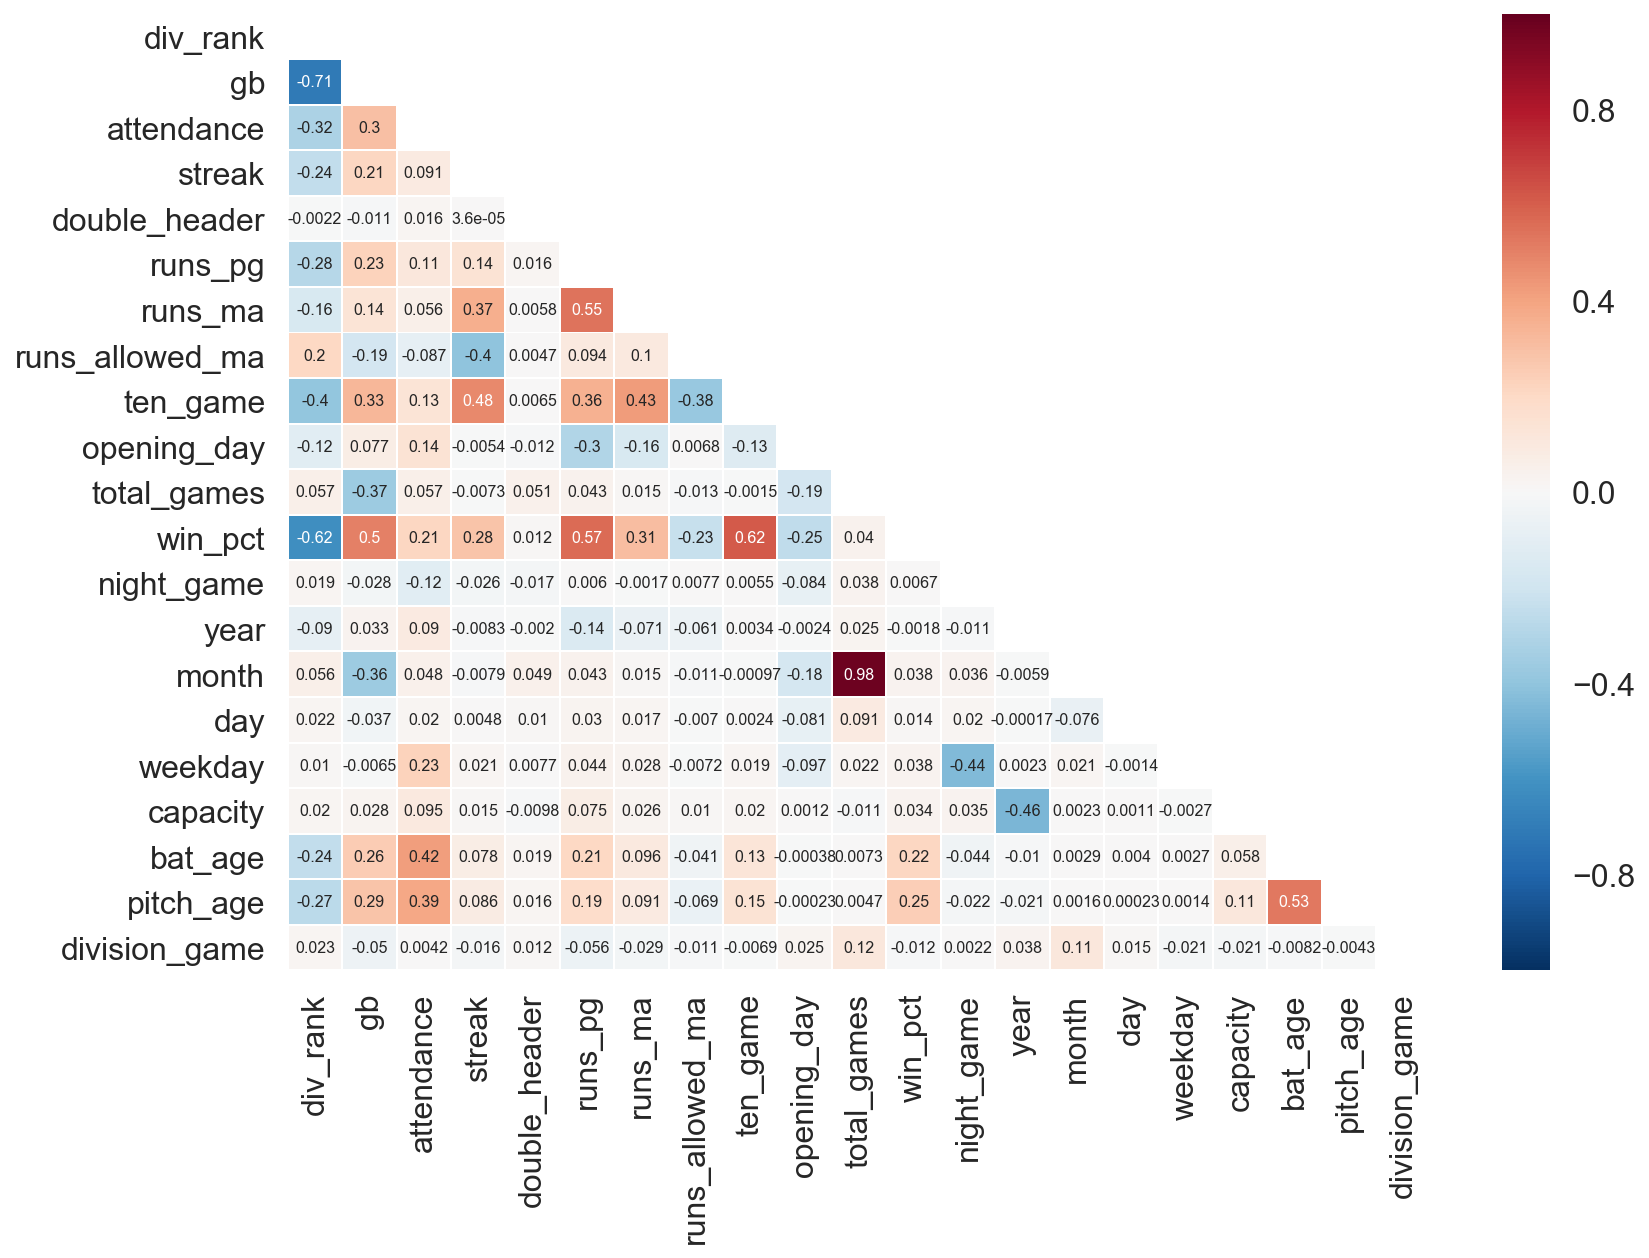

In [176]:
corr = all_teams.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 8})

### Creating variables for modeling

In [177]:
le = LabelEncoder()

all_teams['team_label'] = le.fit_transform(all_teams.team_x)
all_teams['opponent_label'] = le.fit_transform(all_teams.opponent)
all_teams['stadium_label'] = le.fit_transform(all_teams.stadium)

In [178]:
all_teams.head()

team_x opponent  div_rank   gb  attendance  streak  double_header   runs_pg  \
0    ANA      BOS         0  0.0       30874       0              0  0.000000   
1    ANA      BOS         3 -1.0       17323      -1              0  5.000000   
2    ANA      BOS         2 -2.5       24977      -3              0  5.273438   
3    ANA      BOS         2 -2.5       20994       1              0  5.294574   
4    ANA      BOS         2 -1.5       20733       2              0  5.300000   

   runs_ma  runs_allowed_ma  ten_game  opening_day  total_games   win_pct  \
0      0.0              5.8       0.0            1            0  0.000000   
1      5.0              5.8       0.0            0            1  0.000000   
2      4.8              5.0       0.3            0          128  0.539062   
3      6.2              5.6       0.4            0          129  0.542636   
4      5.0              5.0       0.4            0          130  0.546154   

   night_game  year  month  day  weekday        stadium  capacity  bat_age  \
0           1  1997      4    2        2  Angel Stadium     33851     29.7   
1           1  1997      4    3        3  Angel Stadium     33851     29.7   
2           1  1997      8   22        4  Angel Stadium     33851     29.7   
3           0  1997      8   23        5  Angel Stadium     33851     29.7   
4           0  1997      8   24        6  Angel Stadium     33851     29.7   

   pitch_age  division_game  team_label  opponent_label  stadium_label  
0       28.3              0           0               4              1  
1       28.3              0           0               4              1  
2       28.3              0           0               4              1  
3       28.3              0           0               4              1  
4       28.3              0           0               4              1

## Building Models

### Linear Model

In [77]:
X = all_teams.drop(['team_x', 'opponent', 'stadium', 'attendance'], axis = 1)
y = all_teams.attendance

In [78]:
ss = StandardScaler()
Xscaled = ss.fit_transform(X)

In [79]:
Xscaled = add_constant(Xscaled)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 86)

In [81]:
lin_model = OLS(y_train, X_train).fit()

In [82]:
lin_pred = lin_model.predict(X_test)
lin_model_score = r2_score(y_test, lin_pred)

print "R^2 score:", lin_model_score

R^2 score: 0.383435113379


In [83]:
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1127.
Date:                Wed, 24 May 2017   Prob (F-statistic):               0.00
Time:                        14:23:07   Log-Likelihood:            -4.5989e+05
No. Observations:               43690   AIC:                         9.198e+05
Df Residuals:                   43666   BIC:                         9.200e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.973e+04     43.169    688.721      0.000    2.96e+04    2.98e+04
x1          -637.5120     73.923     -8.624      0.000    -782.402    -492.622
x2          1741.0249     71.496     24.351      0.000    1600.890    1881.159
x3          -142.7162     54.537     -2.617      0.009    -249.610     -35.822
x4            26.6014     43.039      0.618      0.537     -57.756     110.959
x5            71.5538     63.624      1.125      0.261     -53.151     196.259
x6           136.0879     59.553      2.285      0.022      19.363     252.813
x7          -220.2313     53.194     -4.140      0.000    -324.493    -115.969
x8          -101.7523     64.098     -1.587      0.112    -227.385      23.881
x9          2117.4558     49.481     42.793      0.000    2020.472    2214.440
x10         2581.4392    510.437      5.057      0.000    1580.973    3581.906
x11          297.7990     77.402      3.847      0.000     146.089     449.509
x12          206.4470     48.817      4.229      0.000     110.764     302.130
x13         1560.4821     52.503     29.722      0.000    1457.574    1663.390
x14        -1043.7468    509.180     -2.050      0.040   -2041.749     -45.744
x15          151.4425     95.613      1.584      0.113     -35.960     338.845
x16         2924.2964     48.668     60.087      0.000    2828.906    3019.687
x17         1485.6947     49.554     29.981      0.000    1388.567    1582.822
x18         2938.7705     51.616     56.935      0.000    2837.601    3039.940
x19         1867.3057     52.671     35.452      0.000    1764.069    1970.542
x20            0.7791     43.689      0.018      0.986     -84.853      86.411
x21         -718.3112     43.994    -16.328      0.000    -804.540    -632.082
x22         -220.4921     43.260     -5.097      0.000    -305.282    -135.703
x23        -1165.0787     43.632    -26.702      0.000   -1250.598   -1079.559
==============================================================================
Omnibus:                      393.157   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              404.062
Skew:                           0.231   Prob(JB):                     1.82e-88
Kurtosis:                       3.088   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Creating functions for Evaluating Models

In [94]:
def evaluate(model):        
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_score = r2_score(y_test, pred)
    
    s = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
        
    print "R^2 score:", model_score
    print "Cross Validation Score: {:0.5} ± {:0.5}".format(s.mean().round(5), s.std().round(5))
    
    df = pd.DataFrame(columns=['attendance', 'predictions', 'residuals'])
    df.attendance = y
    df.predictions = model.predict(Xscaled)
    df.residuals = df.attendance - df.predictions
    df.plot(x='predictions', y='residuals', kind='scatter')
    plt.show()

In [95]:
def feat_imp(model):
    feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance']
                                      ).sort_values('importance', ascending=False).reset_index()
    print feature_importances
    return feature_importances

### Random Forest Regressor

In [96]:
X = all_teams.drop(['team_x', 'opponent', 'stadium', 'attendance'], axis = 1)
y = all_teams.attendance

In [97]:
ss = StandardScaler()
Xscaled = ss.fit_transform(X)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 86)

In [99]:
rf = RandomForestRegressor(n_estimators=300)

R^2 score: 0.787070821896
Cross Validation Score: 0.61331 ± 0.03387


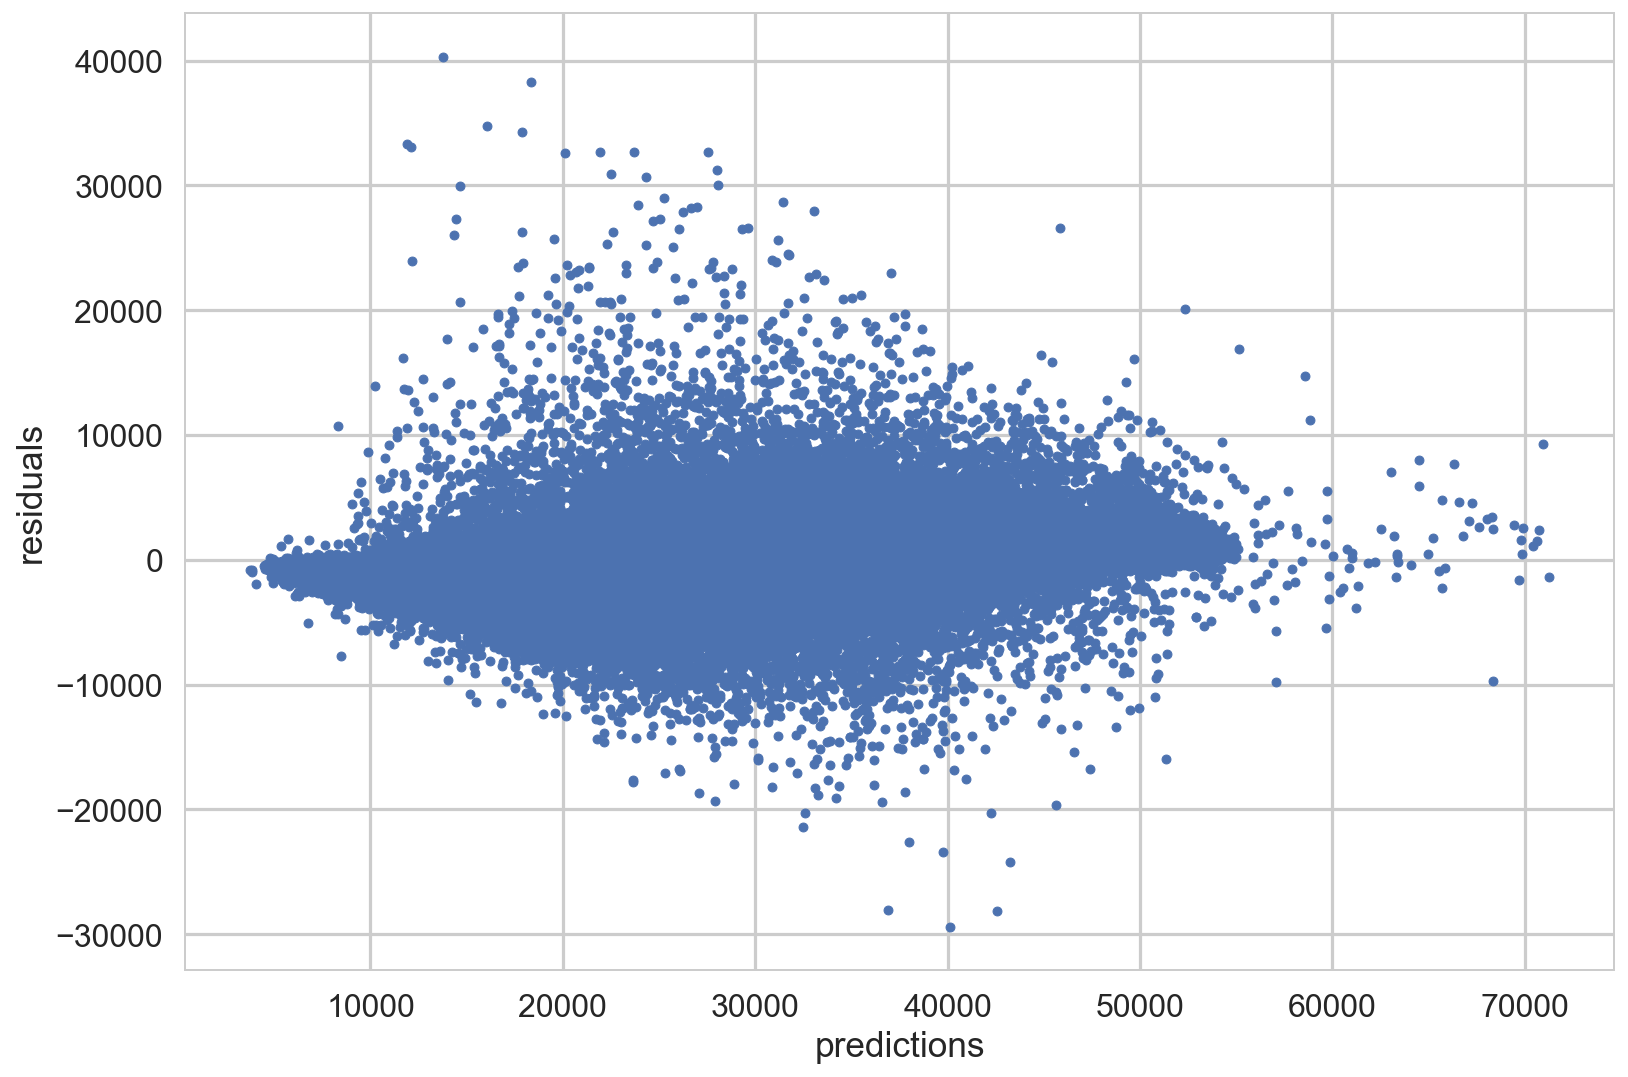

CPU times: user 2min 12s, sys: 1.45 s, total: 2min 13s
Wall time: 5min 10s


In [100]:
%time evaluate(rf)

In [101]:
rf_featimp = feat_imp(rf)

              index  importance
0           bat_age    0.172520
1          capacity    0.098876
2     stadium_label    0.092663
3         pitch_age    0.092633
4           weekday    0.080468
5              year    0.062625
6       total_games    0.057343
7        team_label    0.055297
8           win_pct    0.052056
9           runs_pg    0.039642
10               gb    0.034424
11      opening_day    0.026616
12   opponent_label    0.022321
13              day    0.021655
14  runs_allowed_ma    0.020031
15          runs_ma    0.019780
16         div_rank    0.013060
17           streak    0.011900
18         ten_game    0.010581
19            month    0.006137
20       night_game    0.005267
21    division_game    0.003258
22    double_header    0.000846


In [92]:
def rf_gs():
    params = {
        'max_features' : [0.5, 0.75, 'auto', 'sqrt'],
        'max_depth' : [20, 30, None],
    }

    gs_rf = GridSearchCV(rf, params, n_jobs=-1, cv=5)
    gs_rf.fit(X_train, y_train)

    print gs_rf.best_params_

In [93]:
%time rf_gs()

{'max_features': 0.5, 'max_depth': None}
CPU times: user 1min 6s, sys: 1.37 s, total: 1min 7s
Wall time: 16min 18s


In [102]:
rf2 = RandomForestRegressor(n_estimators=300, max_features=0.5, max_depth=None)

R^2 score: 0.790244293305
Cross Validation Score: 0.63611 ± 0.03262


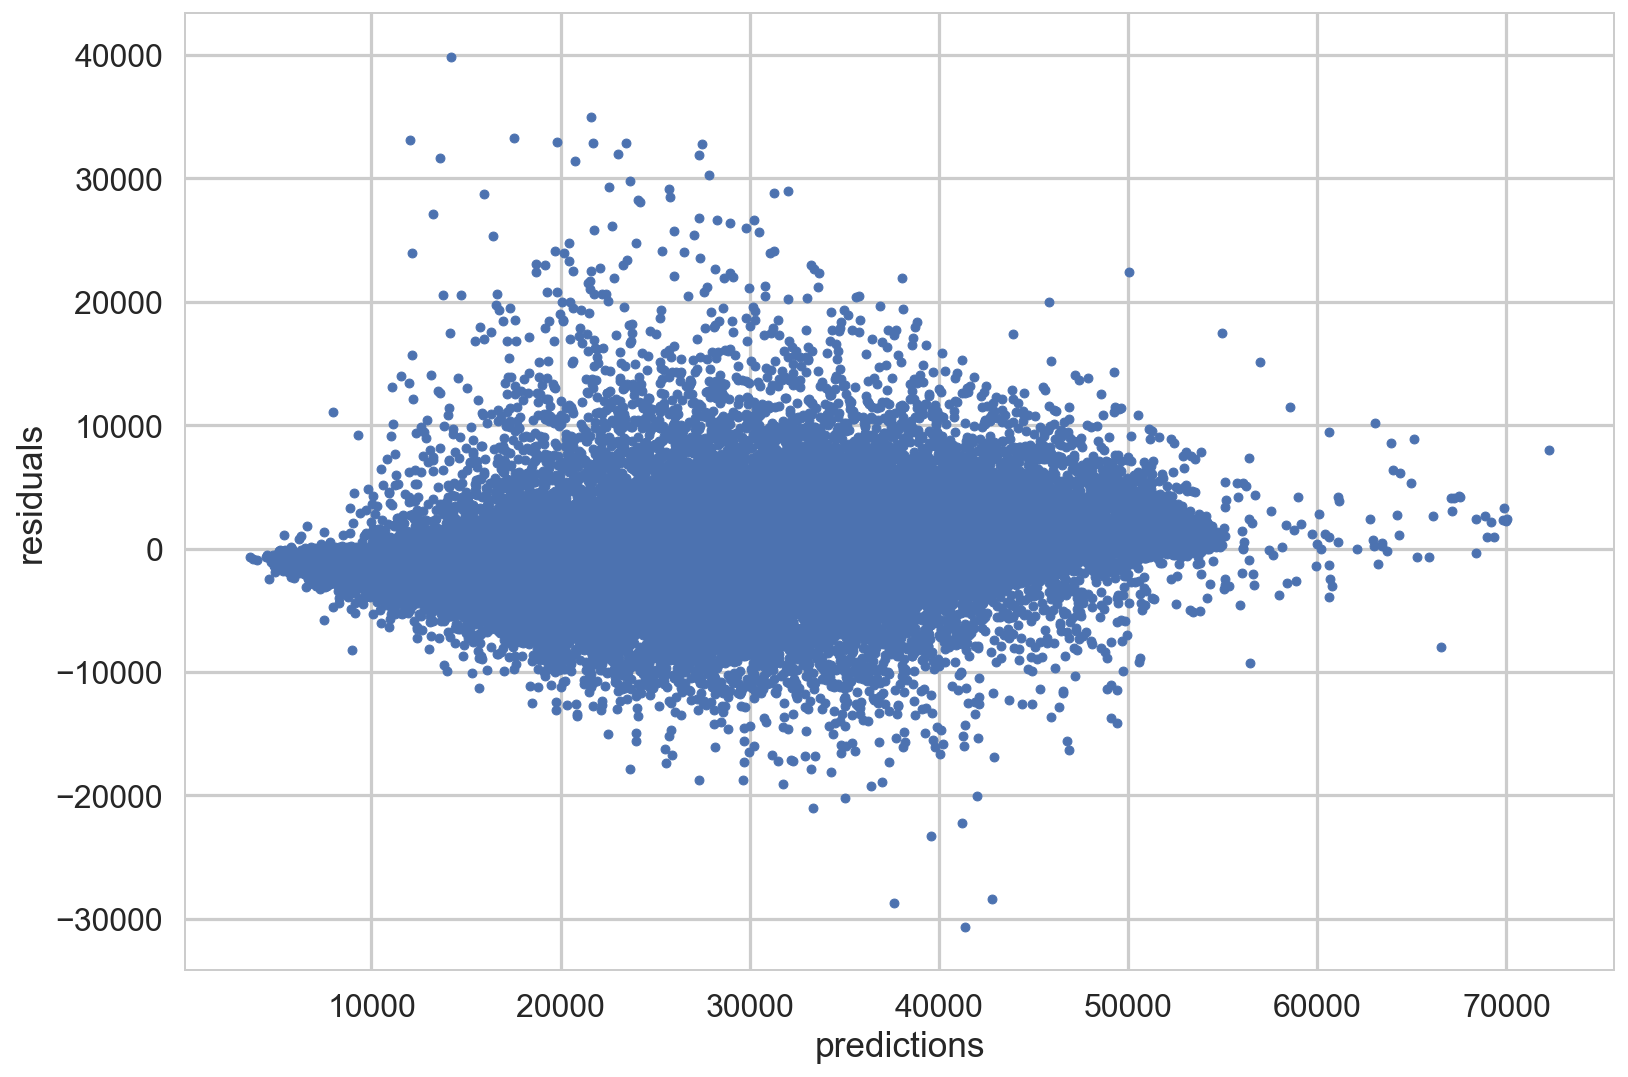

CPU times: user 1min 6s, sys: 2.46 s, total: 1min 9s
Wall time: 2min 38s


In [103]:
%time evaluate(rf2)

In [105]:
rf2_featimp = feat_imp(rf2)

              index  importance
0           bat_age    0.139272
1         pitch_age    0.112847
2     stadium_label    0.092340
3          capacity    0.091930
4           weekday    0.081244
5           win_pct    0.059205
6              year    0.059197
7        team_label    0.057738
8       total_games    0.052041
9           runs_pg    0.040856
10               gb    0.034266
11         div_rank    0.024856
12   opponent_label    0.021926
13              day    0.021423
14          runs_ma    0.021048
15      opening_day    0.020790
16  runs_allowed_ma    0.020305
17            month    0.014499
18           streak    0.012582
19         ten_game    0.011701
20       night_game    0.005431
21    division_game    0.003682
22    double_header    0.000821


### Gradient Boosting Regressor

In [235]:
X = all_teams.drop(['team_x', 'opponent', 'stadium', 'attendance'], axis = 1)
y = all_teams.attendance

In [108]:
ss = StandardScaler()
Xscaled = ss.fit_transform(X)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 86)

In [110]:
gbr = GradientBoostingRegressor(n_estimators=300)

R^2 score: 0.712274298955
Cross Validation Score: 0.61791 ± 0.0443


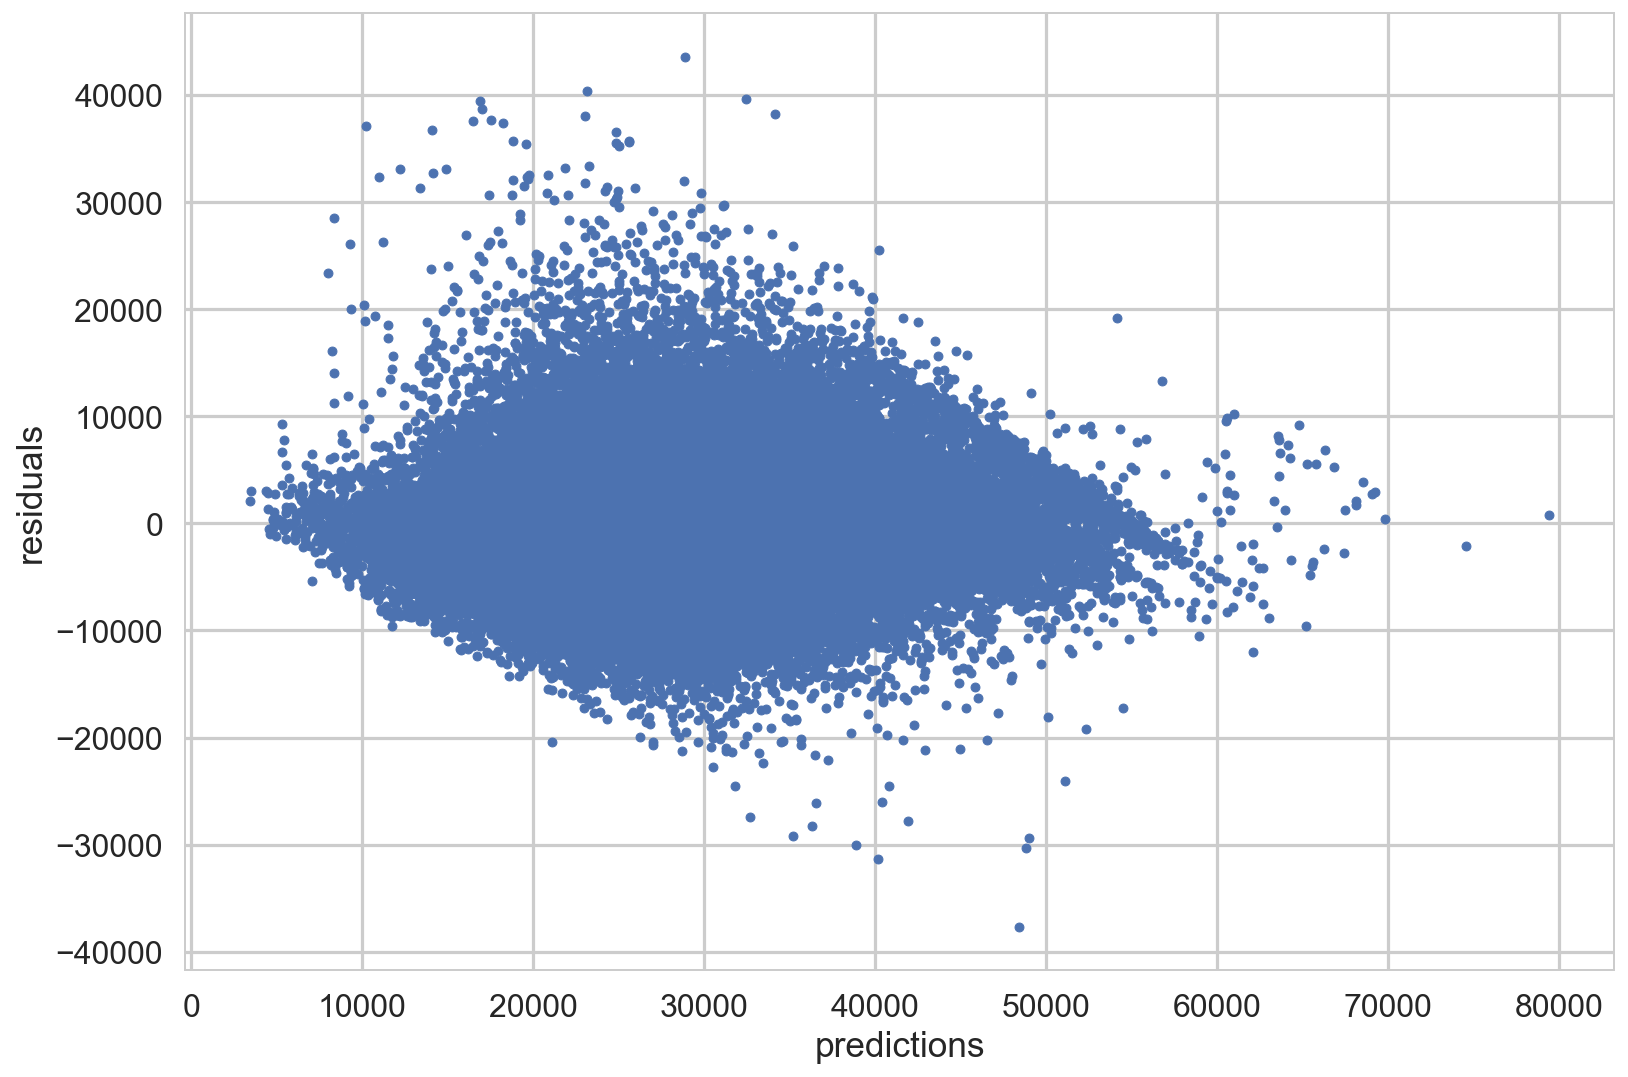

CPU times: user 17.9 s, sys: 195 ms, total: 18.1 s
Wall time: 41.2 s


In [111]:
%time evaluate(gbr)

In [112]:
def gbr_gs():
    params = {
        'max_features' : [0.5, 0.75, 'auto', 'sqrt'],
        'max_depth' : [5, 8, 10, 15],
    }

    gs_gbr = GridSearchCV(gbr, params, n_jobs=-1, cv=5)
    gs_gbr.fit(X_train, y_train)

    print gs_gbr.best_params_

In [113]:
%time gbr_gs()

{'max_features': 0.75, 'max_depth': 10}
CPU times: user 2min 45s, sys: 1.98 s, total: 2min 47s
Wall time: 1h 45min 57s


In [114]:
gbr2 = GradientBoostingRegressor(n_estimators=300, max_features=0.75, max_depth=10)

R^2 score: 0.833185919514
Cross Validation Score: 0.68297 ± 0.04581


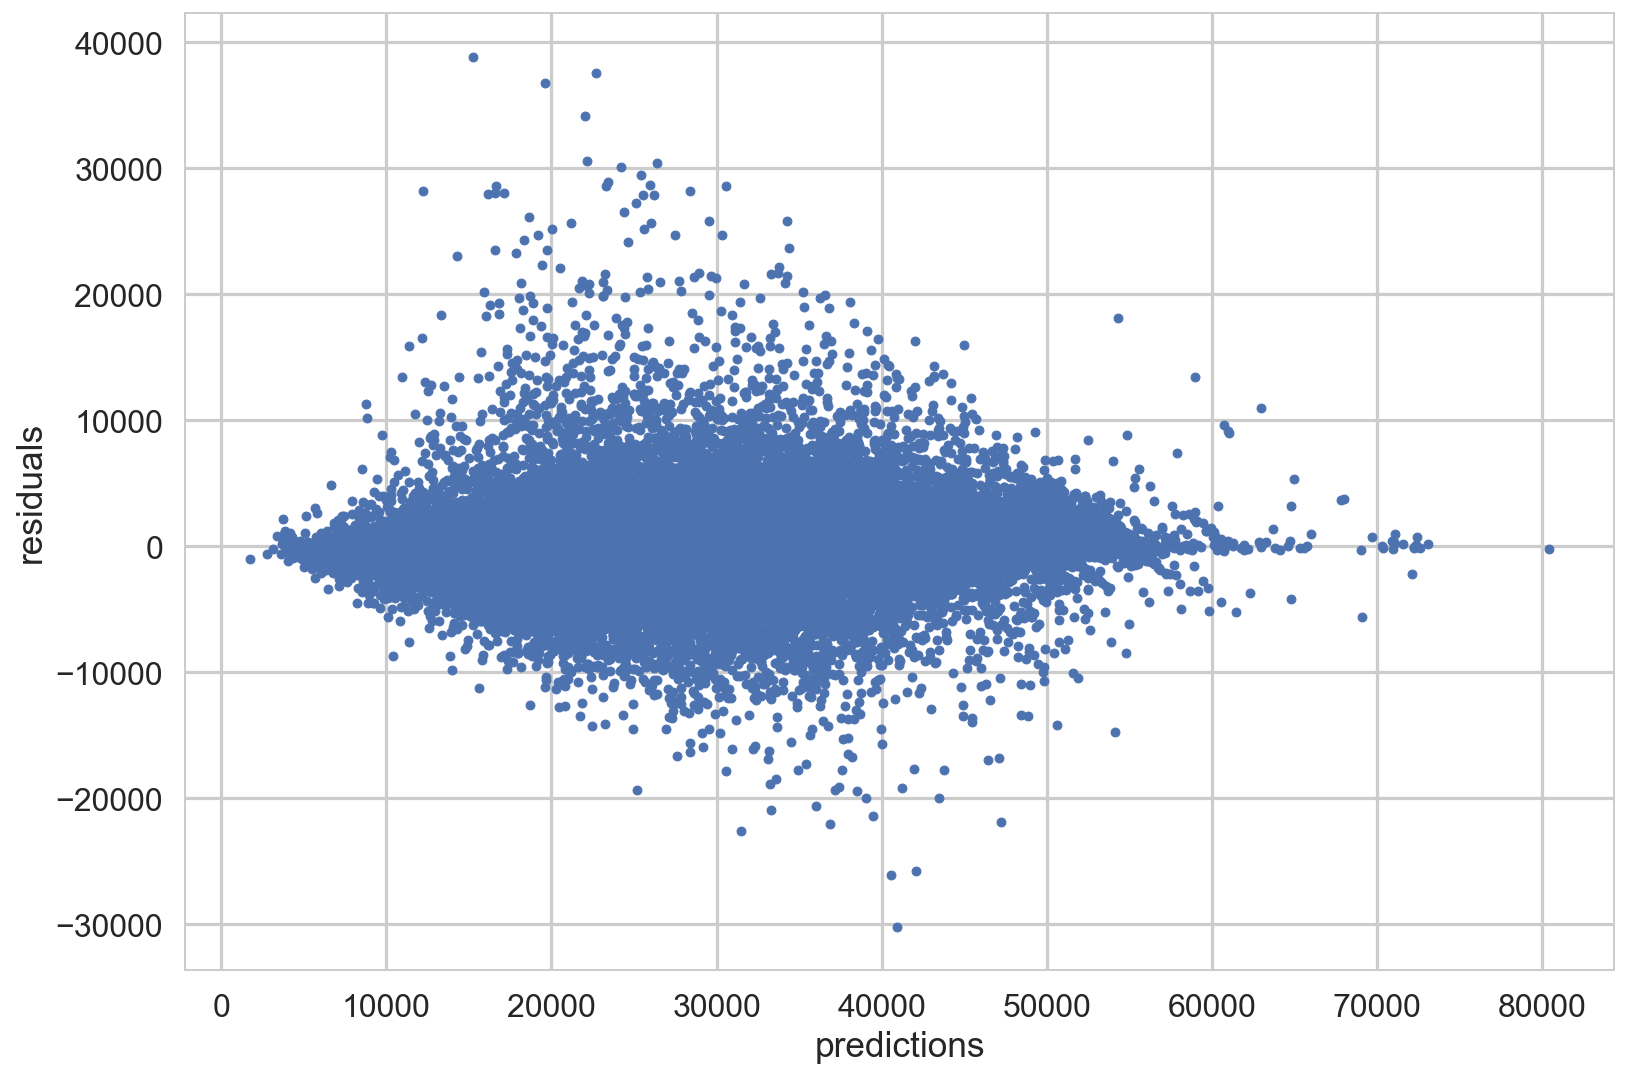

CPU times: user 2min 50s, sys: 959 ms, total: 2min 51s
Wall time: 7min 31s


In [115]:
%time evaluate(gbr2)

In [116]:
gbr2_featimp = feat_imp(gbr2)

              index  importance
0           runs_pg    0.098775
1           win_pct    0.085350
2       total_games    0.077553
3          capacity    0.068411
4    opponent_label    0.057294
5              year    0.057244
6           bat_age    0.054831
7                gb    0.054233
8         pitch_age    0.052930
9               day    0.052322
10          runs_ma    0.051979
11  runs_allowed_ma    0.051084
12       team_label    0.046974
13    stadium_label    0.044861
14          weekday    0.040013
15           streak    0.032922
16         ten_game    0.026405
17         div_rank    0.014332
18            month    0.010400
19       night_game    0.009512
20    division_game    0.007596
21      opening_day    0.003400
22    double_header    0.001578


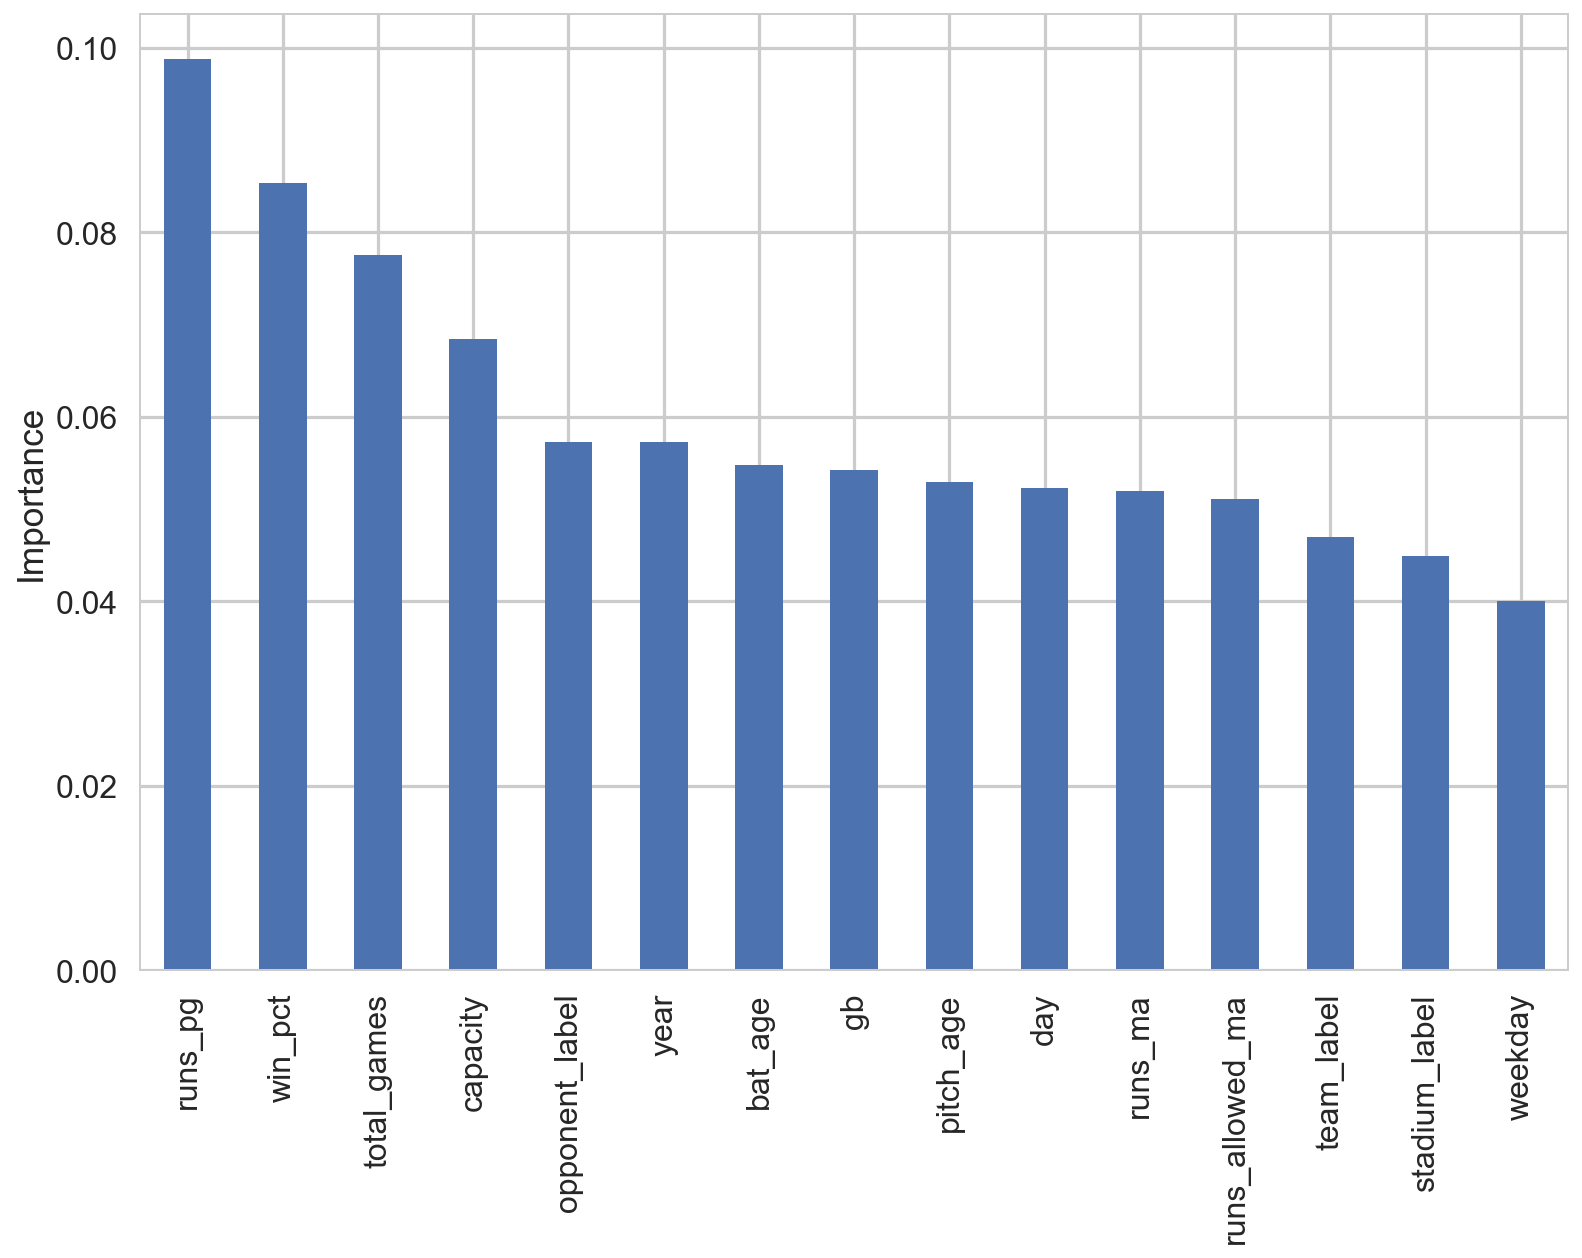

In [190]:
gbr2_featimp[0:15].plot(x='index', y='importance', kind='bar')
# plt.title('Feature Importances', fontsize=25)
plt.xlabel('   ')
plt.ylabel('Importance')
plt.legend().set_visible(False)
plt.savefig('../images/feature-importances.png')

---

# Bayesian Inference

In [201]:
all_teams = pd.read_csv('../data/all-teams-1990-2016.csv')

In [202]:
all_teams.head()

date team_x opponent  div_rank   gb                       time  \
0  1997-04-02    ANA      BOS         0  0.0  0 days 03:47:00.000000000   
1  1997-04-03    ANA      BOS         3 -1.0  0 days 02:07:00.000000000   
2  1997-08-22    ANA      BOS         2 -2.5  0 days 03:25:00.000000000   
3  1997-08-23    ANA      BOS         2 -2.5  0 days 02:49:00.000000000   
4  1997-08-24    ANA      BOS         2 -1.5  0 days 02:36:00.000000000   

   attendance  streak  double_header   runs_pg  runs_ma  runs_allowed_ma  \
0       30874       0              0  0.000000      0.0              5.8   
1       17323      -1              0  5.000000      5.0              5.8   
2       24977      -3              0  5.273438      4.8              5.0   
3       20994       1              0  5.294574      6.2              5.6   
4       20733       2              0  5.300000      5.0              5.0   

   ten_game  opening_day  total_games   win_pct  night_game  year  month  day  \
0       0.0            1            0  0.000000           1  1997      4    2   
1       0.0            0            1  0.000000           1  1997      4    3   
2       0.3            0          128  0.539062           1  1997      8   22   
3       0.4            0          129  0.542636           0  1997      8   23   
4       0.4            0          130  0.546154           0  1997      8   24   

   weekday weekday_name        stadium  capacity  bat_age  pitch_age  \
0        2    Wednesday  Angel Stadium     33851     29.7       28.3   
1        3     Thursday  Angel Stadium     33851     29.7       28.3   
2        4       Friday  Angel Stadium     33851     29.7       28.3   
3        5     Saturday  Angel Stadium     33851     29.7       28.3   
4        6       Sunday  Angel Stadium     33851     29.7       28.3   

   division_game  
0              0  
1              0  
2              0  
3              0  
4              0

In [203]:
import pymc3 as pm
import pydot

### Comparing Saturday Games to Wednesday Games

In [204]:
sat = all_teams[all_teams.weekday_name == 'Saturday'].attendance.values
wed = all_teams[all_teams.weekday_name == 'Wednesday'].attendance.values

In [205]:
prior = all_teams[(all_teams.weekday_name != 'Saturday') & (all_teams.weekday_name != 'Wednesday')].attendance.values

In [206]:
prior_mean = np.mean(prior)
prior_std = np.std(prior)

In [207]:
print prior_mean
print prior_std

29235.6916758
11389.5899665


In [208]:
with pm.Model() as model:

    sat_mean = pm.Normal('sat_mean', prior_mean, sd=prior_std)
    wed_mean = pm.Normal('wed_mean', prior_mean, sd=prior_std)

In [209]:
std_prior_lower = 5000.0
std_prior_upper = 15000.0

with model:
    
    sat_std = pm.Uniform('sat_std', lower=std_prior_lower, upper=std_prior_upper)
    wed_std = pm.Uniform('wed_std', lower=std_prior_lower, upper=std_prior_upper)

In [210]:
with model:

    grp_sat = pm.Normal('group_sat', mu=sat_mean, sd=sat_std, observed=sat)
    grp_wed = pm.Normal('group_wed', mu=wed_mean, sd=wed_std, observed=wed)

In [211]:
with model:

    diff_of_means = pm.Deterministic('difference of means', sat_mean - wed_mean)
    diff_of_stds = pm.Deterministic('difference of stds', sat_std - wed_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((sat_std**2 + wed_std**2) / 2))

In [212]:
with model:
    trace = pm.sample(20000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2.1055e+05: 100%|██████████| 200000/200000 [01:00<00:00, 3320.38it/s]
Finished [100%]: Average ELBO = -2.1055e+05
100%|██████████| 20000/20000 [00:59<00:00, 338.05it/s]


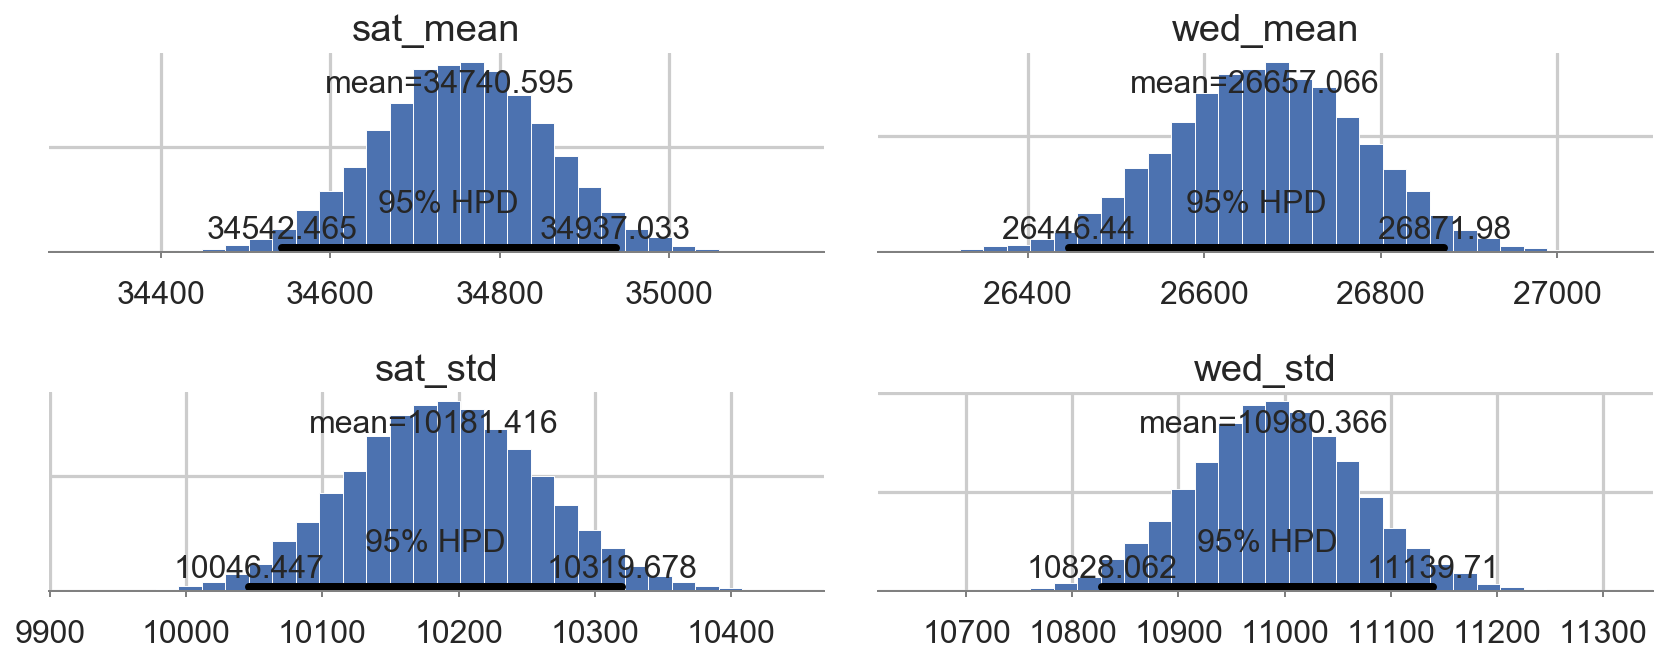

In [213]:
pm.plot_posterior(trace[3000:], varnames=['sat_mean', 'wed_mean', 'sat_std', 'wed_std'])
plt.savefig('../images/weekday-bayes.png')

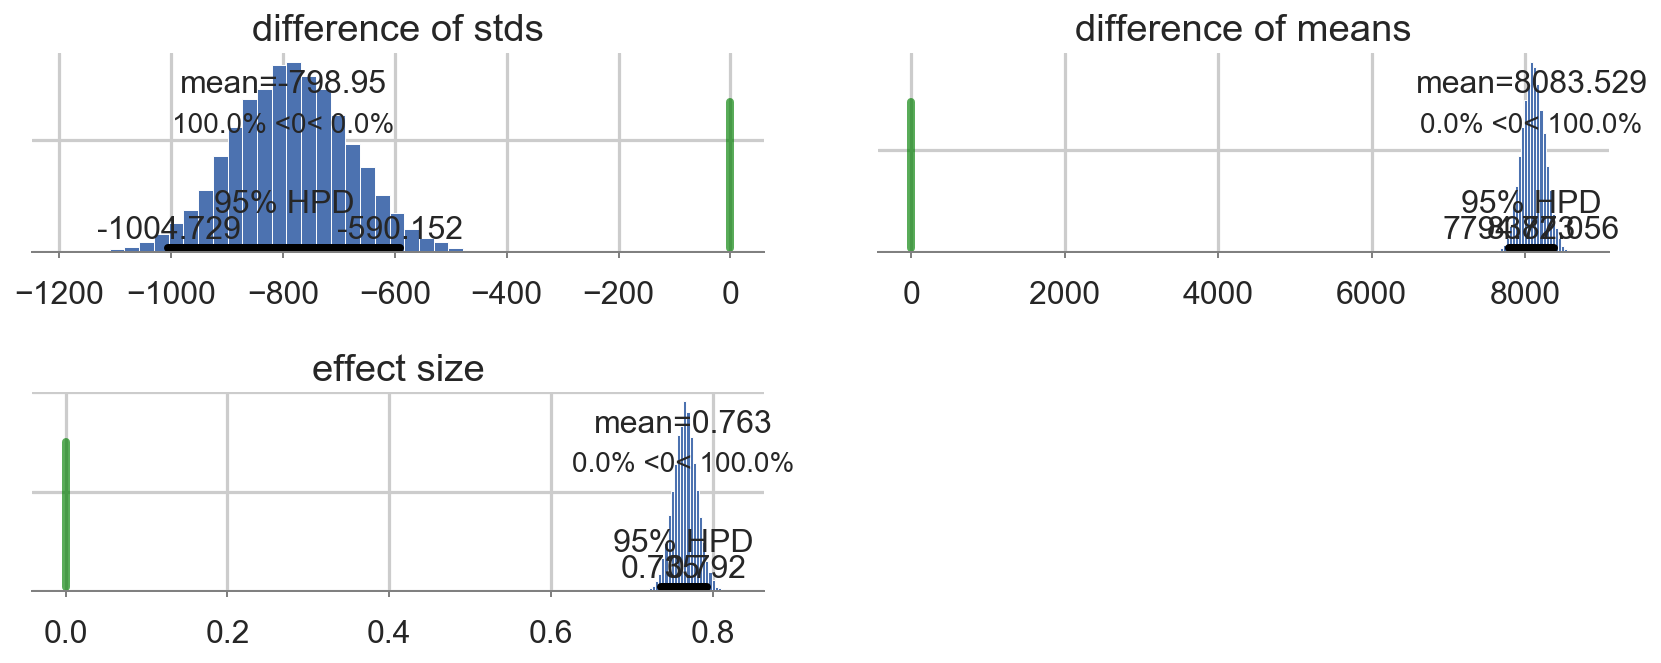

In [216]:
pm.plot_posterior(trace[3000:], varnames=['difference of means', 'difference of stds', 'effect size'], ref_val=0)
plt.savefig('../images/weekday-bayes-diff.png')

### Comparing Two Fan Groups

In [217]:
yearly = pd.read_csv('../data/yearly-team-data.csv')

In [218]:
yearly.head()

team  year        stadium  capacity       team_name division    G  win_pct  \
0  ANA  1997  Angel Stadium     33851  Anaheim Angels  AL West  162    0.519   
1  ANA  1998  Angel Stadium     45050  Anaheim Angels  AL West  162    0.525   
2  ANA  1999  Angel Stadium     45050  Anaheim Angels  AL West  162    0.432   
3  ANA  2000  Angel Stadium     45050  Anaheim Angels  AL West  162    0.506   
4  ANA  2001  Angel Stadium     45050  Anaheim Angels  AL West  162    0.463   

     gb  playoffs  attendance  bat_age  pitch_age top_player  WAR  \
0   6.0         0     1767330     29.7       28.3   T.Salmon  4.9   
1   3.0         0     2519280     28.7       29.8   C.Finley  7.2   
2  25.0         0     2253123     28.8       31.5  R.Velarde  4.2   
3   9.5         0     2066982     27.7       28.9   D.Erstad  8.3   
4  41.0         0     2000919     28.0       28.9    T.Glaus  5.2   

   num_home_games    avg_att_pg  
0            81.0  21818.888889  
1            81.0  31102.222222  
2            81.0  27816.333333  
3            81.0  25518.296296  
4            81.0  24702.703704

In [219]:
active_parks = yearly
for i in yearly.stadium.unique():
    if i not in yearly[yearly.year == 2016].stadium.unique():
        active_parks = active_parks[active_parks.stadium != i]

In [220]:
parks_summary = pd.DataFrame(columns=['stadium', 'first_year', 'avg_capacity', 'capacity_std', 'avg_win_pct', 'avg_attendance'])
for i in active_parks.stadium.unique():
    parks_summary.loc[len(parks_summary)] = [
        i,
        min(active_parks[active_parks.stadium == i].year),
        round(np.mean(active_parks[active_parks.stadium == i].capacity),0) / 1000,
        np.std(active_parks[active_parks.stadium == i].capacity),
        round(np.mean(active_parks[active_parks.stadium == i].win_pct), 3),
        round(np.mean(active_parks[active_parks.stadium == i].attendance),0) / 1000000
    ]

In [221]:
parks_summary.sort_values('avg_capacity').reset_index(drop=True)

stadium first_year  avg_capacity  capacity_std  \
0                Fenway Park       1990        35.460   1600.956431   
1               Marlins Park       2012        36.742      0.000000   
2                   PNC Park       2001        38.309    204.926206   
3                  Tropicana       1998        38.997   5225.982285   
4               Target Field       2010        39.207    262.218479   
5              Wrigley Field       1990        39.816   1098.275818   
6           Kauffman Stadium       1990        39.818   1242.928512   
7              O.co Coliseum       1990        40.656   5170.525357   
8              Comerica Park       2000        41.078    488.903703   
9           Minute Maid Park       2000        41.170    388.102553   
10            Nationals Park       2008        41.547    194.605838   
11                 AT&T Park       2000        41.670    339.702383   
12                Citi Field       2009        41.876     59.062996   
13               Miller Park       2001        41.900      0.000000   
14                Petco Park       2004        42.261    720.041731   
15  Great American Ball Park       2003        42.302     22.999556   
16         Progressive Field       1994        42.773   2203.065268   
17         US Cellular Field       1991        42.805   2356.999764   
18        Citizens Bank Park       2004        43.600     99.886741   
19             Busch Stadium       2006        44.376    655.723750   
20              Safeco Field       2000        47.510    283.201678   
21               Oriole Park       1992        47.634    938.771935   
22               Chase Field       1998        48.725    217.795490   
23           Globe Life Park       1994        48.906    420.249611   
24             Rogers Centre       1990        49.275   1830.952016   
25              Turner Field       1997        49.854    263.716567   
26             Angel Stadium       1990        49.876   8970.838639   
27         Yankee Stadium II       2009        50.025    345.533645   
28               Coors Field       1995        50.386     91.646554   
29            Dodger Stadium       1990        56.000      0.000000   

    avg_win_pct  avg_attendance  
0         0.538        2.676934  
1         0.443        1.800540  
2         0.455        1.948405  
3         0.462        1.488712  
4         0.442        2.582904  
5         0.486        2.729558  
6         0.456        1.720504  
7         0.518        1.804549  
8         0.485        2.466937  
9         0.476        2.472855  
10        0.498        2.290062  
11        0.531        3.232192  
12        0.486        2.495941  
13        0.471        2.558100  
14        0.482        2.404251  
15        0.479        2.177791  
16        0.528        2.275669  
17        0.513        2.034151  
18        0.519        2.996542  
19        0.548        3.388048  
20        0.494        2.504086  
21        0.485        2.690464  
22        0.488        2.453290  
23        0.511        2.599276  
24        0.506        2.514769  
25        0.552        2.622605  
26        0.516        2.663115  
27        0.563        3.452458  
28        0.469        2.864747  
29        0.528        3.293150

In [222]:
bayes = all_teams[all_teams.year >= 2008]

In [223]:
wsn = bayes[(bayes.team_x == 'WSN') & (bayes.stadium == 'Nationals Park')].attendance.values
nym = bayes[(bayes.team_x == 'NYM') & (bayes.stadium == 'Citi Field')].attendance.values

In [224]:
prior = bayes[(bayes.team_x != 'WSN') & (bayes.team_x != 'NYM')].attendance.values

In [225]:
prior_mean = np.mean(prior)
prior_std = np.std(prior)

In [226]:
print prior_mean
print prior_std

30638.3054354
10365.557746


In [227]:
with pm.Model() as model:

    wsn_mean = pm.Normal('wsn_mean', prior_mean, sd=prior_std)
    nym_mean = pm.Normal('nym_mean', prior_mean, sd=prior_std)

In [228]:
std_prior_lower = 5000.0
std_prior_upper = 15000.0

with model:
    
    wsn_std = pm.Uniform('wsn_std', lower=std_prior_lower, upper=std_prior_upper)
    nym_std = pm.Uniform('nym_std', lower=std_prior_lower, upper=std_prior_upper)

In [229]:
with model:

    grp_wsn = pm.Normal('group_wsn', mu=wsn_mean, sd=wsn_std, observed=wsn)
    grp_nym = pm.Normal('group_nym', mu=nym_mean, sd=nym_std, observed=nym)

In [230]:
with model:

    diff_of_means = pm.Deterministic('difference of means', wsn_mean - nym_mean)
    diff_of_stds = pm.Deterministic('difference of stds', wsn_std - nym_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((wsn_std**2 + nym_std**2) / 2))

In [231]:
with model:
    trace = pm.sample(20000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -14,009: 100%|██████████| 200000/200000 [00:19<00:00, 10108.33it/s]
Finished [100%]: Average ELBO = -14,009
100%|██████████| 20000/20000 [00:20<00:00, 954.33it/s] 


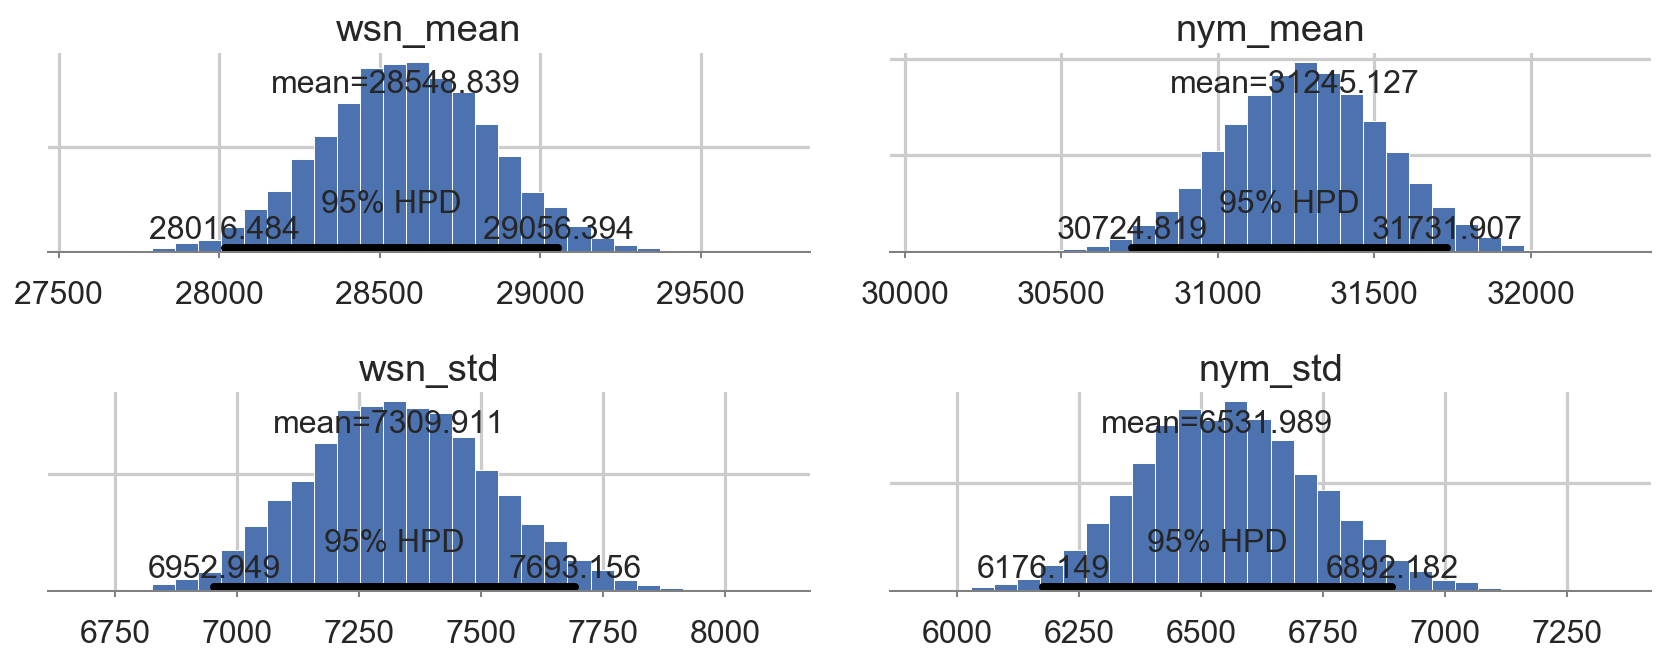

In [232]:
pm.plot_posterior(trace[3000:], varnames=['wsn_mean', 'nym_mean', 'wsn_std', 'nym_std'])
plt.savefig('../images/wsn-nym-bayes.png')

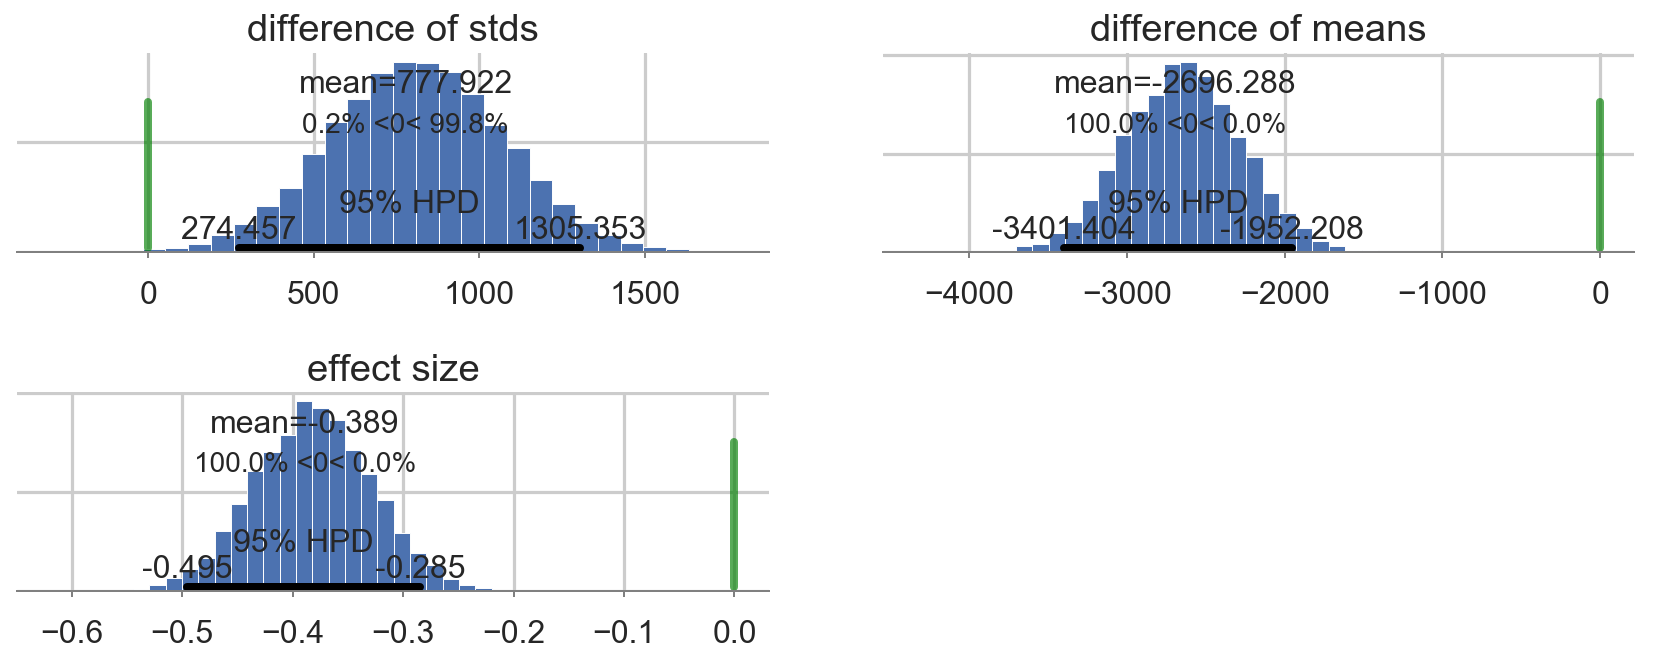

In [233]:
pm.plot_posterior(trace[3000:], varnames=['difference of means', 'difference of stds', 'effect size'], ref_val=0)
plt.savefig('../images/wsn-nym-bayes-diff.png')